# Import Everything I Need

In [3]:
## Essential Imports: 
import os
import numpy as np
from pathlib import Path
from pzflow.examples import get_galaxy_data
import tables_io

## RAIL-Specific Imports: 
import rail
from rail.creation.degradation import LSSTErrorModel, InvRedshiftIncompleteness
from rail.creation.engines.flowEngine import FlowModeler, FlowCreator, FlowPosterior
from rail.core.data import TableHandle
from rail.core.stage import RailStage
from rail.core.utilStages import ColumnMapper, TableConverter

from rail.estimation.algos.flexzboost import Inform_FZBoost, FZBoost

from rail.evaluation.evaluator import Evaluator

## Data Storage: 
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

## Data Formatting: (from different codes) 
from rail.core.utils import RAILDIR
flow_file = os.path.join(RAILDIR, 'examples/goldenspike/data/pretrained_flow.pkl')
bands = ['u','g','r','i','z','y']
band_dict = {band:f'mag_{band}_lsst' for band in bands}
rename_dict = {f'mag_{band}_lsst_err':f'mag_err_{band}_lsst' for band in bands}

In [28]:
import rail
from rail.evaluation.metrics.cdeloss import *
from rail.evaluation.evaluator import Evaluator
from rail.core.data import QPHandle, TableHandle
from rail.core.stage import RailStage
#from rail.evaluation.utils import plot_pit_qq, ks_plot
import qp 
import os
%matplotlib inline
%reload_ext autoreload
%autoreload 2

DS = RailStage.data_store
DS.__class__.allow_overwrite = True

# Setting Up the Flow Engine 

This cell is slow, takes about 1.5 mins

In [4]:
#path to access the data 
DATA_DIR = Path().resolve() / "data"
DATA_DIR.mkdir(exist_ok=True)

catalog_file = DATA_DIR / "base_catalog.pq"

#array of 100,000 galaxies w/ 7 attributes for each: redshift & ugrizy
catalog = get_galaxy_data().rename(band_dict, axis=1) 

#turns array into a table 
tables_io.write(catalog, str(catalog_file.with_suffix("")), catalog_file.suffix[1:])

catalog_file = str(catalog_file)
flow_file = str(DATA_DIR / "trained_flow.pkl")

#we set up the stage 
flow_modeler_params = {
    "name": "flow_modeler",
    "input": catalog_file,
    "model": flow_file,
    "seed": 0,
    "phys_cols": {"redshift": [0, 3]},
    "phot_cols": {
        "mag_u_lsst": [17, 35],
        "mag_g_lsst": [16, 32],
        "mag_r_lsst": [15, 30],
        "mag_i_lsst": [15, 30],
        "mag_z_lsst": [14, 29],
        "mag_y_lsst": [14, 28],
    },
    "calc_colors": {"ref_column_name": "mag_i_lsst"},
}

#we make the stage
flow_modeler = FlowModeler.make_stage(**flow_modeler_params)

#we use the stage to make a model 
flow_modeler.fit_model()

#now we have a model; the next thing to do is to pull datasets from it (and degrade them)

Inserting handle into data store.  input: /Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/base_catalog.pq, flow_modeler
Training 30 epochs 
Loss:
(0) 21.3266
(1) 6.7267
(2) 2.0761
(3) 2.6037
(4) -0.0680
(5) 0.4129
(6) 0.2506
(7) 0.1637
(8) -1.3346
(9) -1.7669
(10) -1.1823
(11) -1.6267
(12) 3402823273761818485311871060541440.0000
(13) 3402823273761818485311871060541440.0000
(14) -1.0711
(15) -0.6228
(16) 3402823273761818485311871060541440.0000
(17) 3402823273761818485311871060541440.0000
(18) -2.8045
(19) -3.3746
(20) 3402823273761818485311871060541440.0000
(21) -2.4881
(22) -3.2147
(23) -3.7188
(24) -3.4398
(25) -3.7955
(26) -3.3772
(27) 3402823273761818485311871060541440.0000
(28) -3.5247
(29) -4.1677
(30) -3.4874
Inserting handle into data store.  model_flow_modeler: /Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/inprogress_trained_flow.pkl, flow_modeler


In [7]:
# import corner

# Training Set  

In [6]:
flow_modeler.get_handle("model")

In [8]:
#take a sample of 10,000 galaxies from the model created above to use as a training set
flow_creator_train = FlowCreator.make_stage(
    name='flow_creator_train', 
    model=flow_modeler.get_handle("model"), 
    n_samples=10000,
    seed=1235,
)

#an un-degraded training data set containing 10,000 galaxies
orig_train_data = flow_creator_train.sample(10000, 1235)

# the inverse redshift degrader stage
inv_redshift_deg = InvRedshiftIncompleteness.make_stage(
    name='inv_redshift_deg',
    pivot_redshift=1.0,
)

#degraded training set, using inverse redshift degrader 
deg_train_data = inv_redshift_deg(orig_train_data)


Inserting handle into data store.  output_flow_creator_train: inprogress_output_flow_creator_train.pq, flow_creator_train
Inserting handle into data store.  output_inv_redshift_deg: inprogress_output_inv_redshift_deg.pq, inv_redshift_deg


## Undegraded Training Posteriors

This cell takes 1.5-2 minutes 

In [111]:
# only uncomment if you need to remake the output file 

# flow_post_orig_train = FlowPosterior.make_stage(name='truth_post_orig_train', 
#                                              column='redshift',
#                                              grid = np.linspace(0, 2.5, 100),
#                                              model=flow_file,
#                                              data = orig_train_data)

# orig_train_pdfs = flow_post_orig_train.get_posterior(orig_train_data, column='redshift')

Inserting handle into data store.  output_truth_post_orig_train: inprogress_output_truth_post_orig_train.hdf5, truth_post_orig_train


In [146]:
# flow_post_train.inputs[1][1]("foobar")
# help(rail.core.data)

In [8]:
import h5py

orig_train_file = h5py.File('output_truth_post_orig_train.hdf5', 'r')
list(orig_train_file.keys())

orig_train_pdf_data = orig_train_file['data']
orig_train_pdf_meta = orig_train_file['meta']


## Degraded Training Posteriors 

1.5-2 mins : only run if you don't have output_truth_post_deg_train.hdf5 

In [113]:
# flow_post_deg_train = FlowPosterior.make_stage(name='truth_post_deg_train', 
#                                              column='redshift',
#                                              grid = np.linspace(0, 2.5, 100),
#                                              model=flow_file,
#                                              data = deg_train_data)

# deg_train_pdfs = flow_post_deg_train.get_posterior(deg_train_data, column='redshift')

Inserting handle into data store.  output_truth_post_deg_train: inprogress_output_truth_post_deg_train.hdf5, truth_post_deg_train


In [8]:
import h5py

deg_train_file = h5py.File('output_truth_post_deg_train.hdf5', 'r')
list(deg_train_file.keys())

deg_train_pdf_data = deg_train_file['data']
deg_train_pdf_meta = deg_train_file['meta']

## Plots 

In [114]:
orig_train_yvals = orig_train_pdf_data['yvals']
orig_train_xvals = orig_train_pdf_meta['xvals'] 


deg_train_yvals = deg_train_pdf_data['yvals']
deg_train_xvals = deg_train_pdf_meta['xvals']

In [267]:
orig = np.asarray(orig_train_yvals)
deg = np.asarray(deg_train_yvals)
orig = orig.tolist()
deg = deg.tolist()

end = deg[-1]
stop = orig.index(end)

for i in range(0, stop):
    if orig[i] != deg[i]:
        deg.insert(i, np.zeros(100))

diff = len(orig) - len(deg)
for i in range(1, diff+1):
    deg.insert(stop+i, np.zeros(100))

deg_arr = np.asarray(deg)

Text(0.5, 0, 'Redshift (z)')

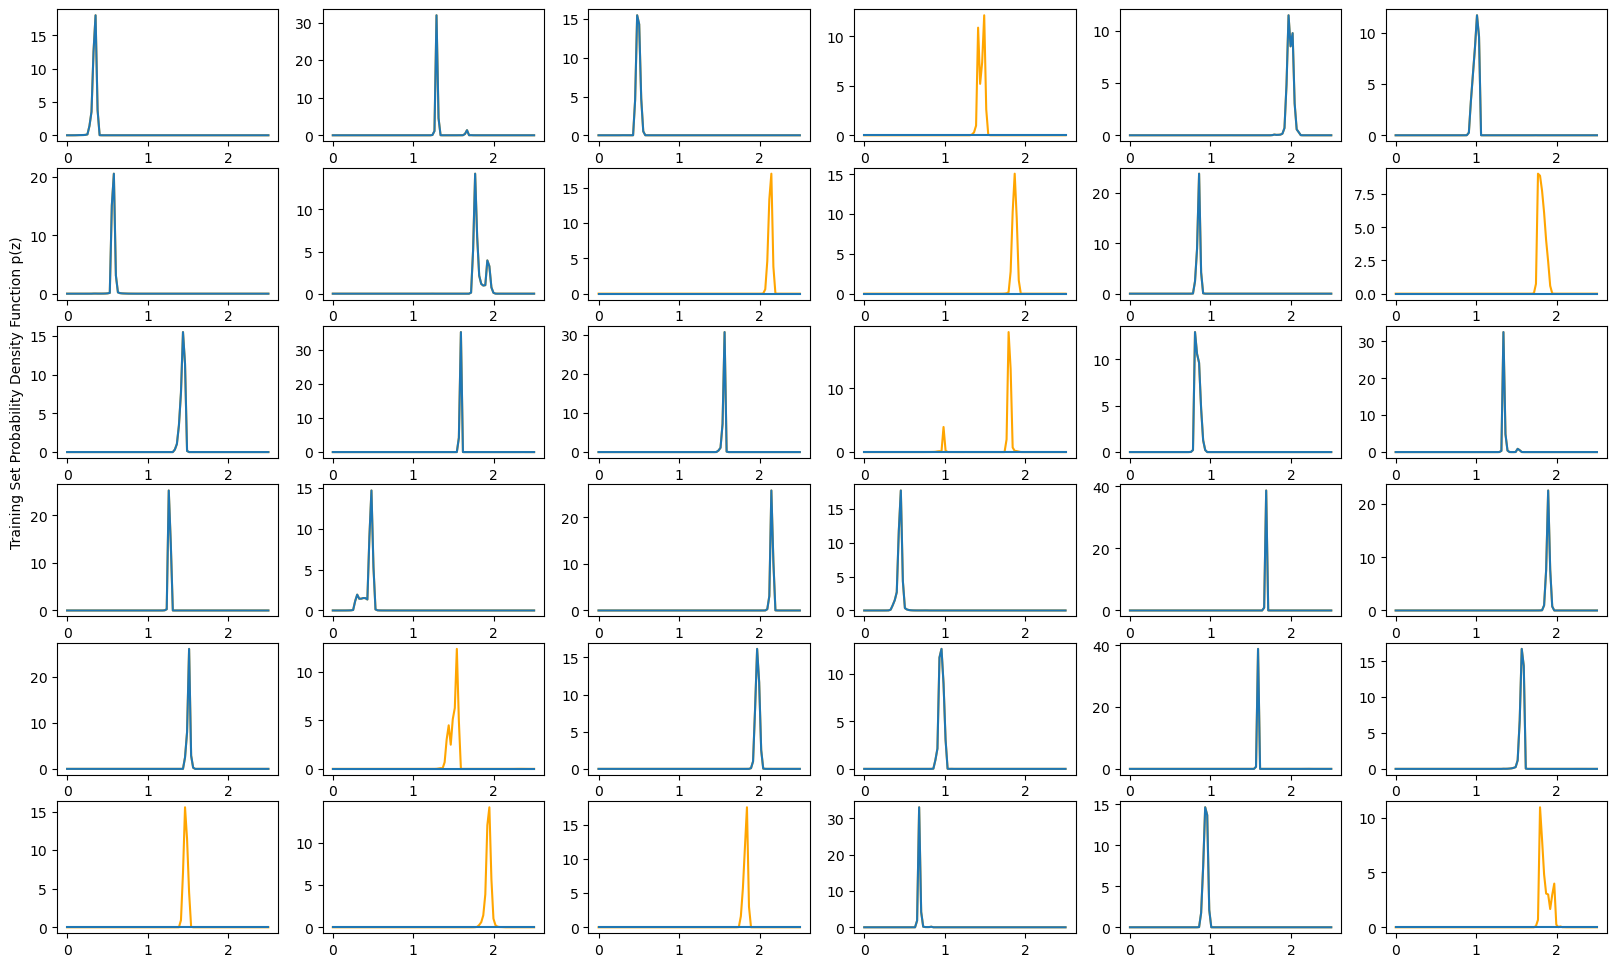

In [269]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 6, ncols = 6, figsize = (20, 12)) 

ct = 0
for i in range(0, 6):
    for j in range(0, 6):
        axes[i][j].plot(orig_train_xvals[0], orig_train_yvals[ct], color = 'orange') 
        axes[i][j].plot(orig_train_xvals[0], deg_arr[ct])
        ct += 1
axes[2][0].set_ylabel("Training Set Probability Density Function p(z)")
axes[4][2].set_xlabel("Redshift (z)")
# axes[0][4].legend()

In [ ]:
## this is cool but we want the test set
## make for the test set as well 
## compare these to the pdfs that came out of the estimator 

## fun thing to try: run the estimator on the training set, see what happens (it should do really well)

## now I can evaluate posteriors for training and test
## see open chrome tab about evaluating metrics pairwise between 2 ensembles 
## kld comparisons, rmse (?) 
## if you compare for training set estimates as well, they should be very similar 

# Test Set

In [9]:
#take a sample of 100,000 galaxies from the model created above to use as a test set
flow_creator_test = FlowCreator.make_stage(
    name='flow_creator_test', 
    model=flow_modeler.get_handle("model"), 
    n_samples=100000,
    seed=472,
)

#un-degraded test data set, 100,000 galaxies 
orig_test_data = flow_creator_test.sample(100000, 472)

#the LSST error model degrader
lsst_error_model_deg = LSSTErrorModel.make_stage(
    name='lsst_error_model_deg',
    bandNames=band_dict, 
    seed=29,
)

#degraded test set, using LSST error model 
deg_test_data = lsst_error_model_deg(orig_test_data,seed=66)


Inserting handle into data store.  output_flow_creator_test: inprogress_output_flow_creator_test.pq, flow_creator_test
Inserting handle into data store.  output_lsst_error_model_deg: inprogress_output_lsst_error_model_deg.pq, lsst_error_model_deg


## Undegraded Test Posteriors 

v long cells, these take forever :/ running stages took 12-13 & 25-26 mins respectively 

In [68]:
flow_post_orig_test = FlowPosterior.make_stage(name='truth_post_orig_test', 
                                             column='redshift',
                                             grid = np.linspace(0, 2.5, 100),
                                             model=flow_file,
                                             data = orig_test_data)

orig_test_pdfs = flow_post_orig_test.get_posterior(orig_test_data, column='redshift')

Inserting handle into data store.  output_truth_post_orig_test: inprogress_output_truth_post_orig_test.hdf5, truth_post_orig_test


/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/qp/interp_pdf.py:83: RuntimeWarning: invalid value encountered in divide
  self._ycumul = (self._ycumul.T / self._ycumul[:,-1]).T


In [77]:
import h5py

orig_test_file = h5py.File('output_truth_post_orig_test.hdf5', 'r')
list(orig_test_file.keys())

orig_test_pdf_data = orig_test_file['data']
orig_test_pdf_meta = orig_test_file['meta']

## Degraded Test Posteriors 

In [108]:
flow_post_deg_test = FlowPosterior.make_stage(name='truth_post_deg_test', 
                                             column='redshift',
                                             grid = np.linspace(0, 2.5, 100),
                                             model=flow_file,
                                             data = deg_test_data)

deg_test_pdfs = flow_post_deg_test.get_posterior(deg_test_data, column='redshift')

Inserting handle into data store.  output_truth_post_deg_test: inprogress_output_truth_post_deg_test.hdf5, truth_post_deg_test


/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/qp/interp_pdf.py:83: RuntimeWarning: invalid value encountered in divide
  self._ycumul = (self._ycumul.T / self._ycumul[:,-1]).T


In [80]:
import h5py

deg_test_file = h5py.File('output_truth_post_deg_test.hdf5', 'r')
list(deg_test_file.keys())

deg_test_pdf_data = deg_test_file['data']
deg_test_pdf_meta = deg_test_file['meta']

## Plots 

In [81]:
orig_test_yvals = orig_test_pdf_data['yvals']
orig_test_xvals = orig_test_pdf_meta['xvals']

deg_test_yvals = deg_test_pdf_data['yvals']
deg_test_xvals = deg_test_pdf_meta['xvals']

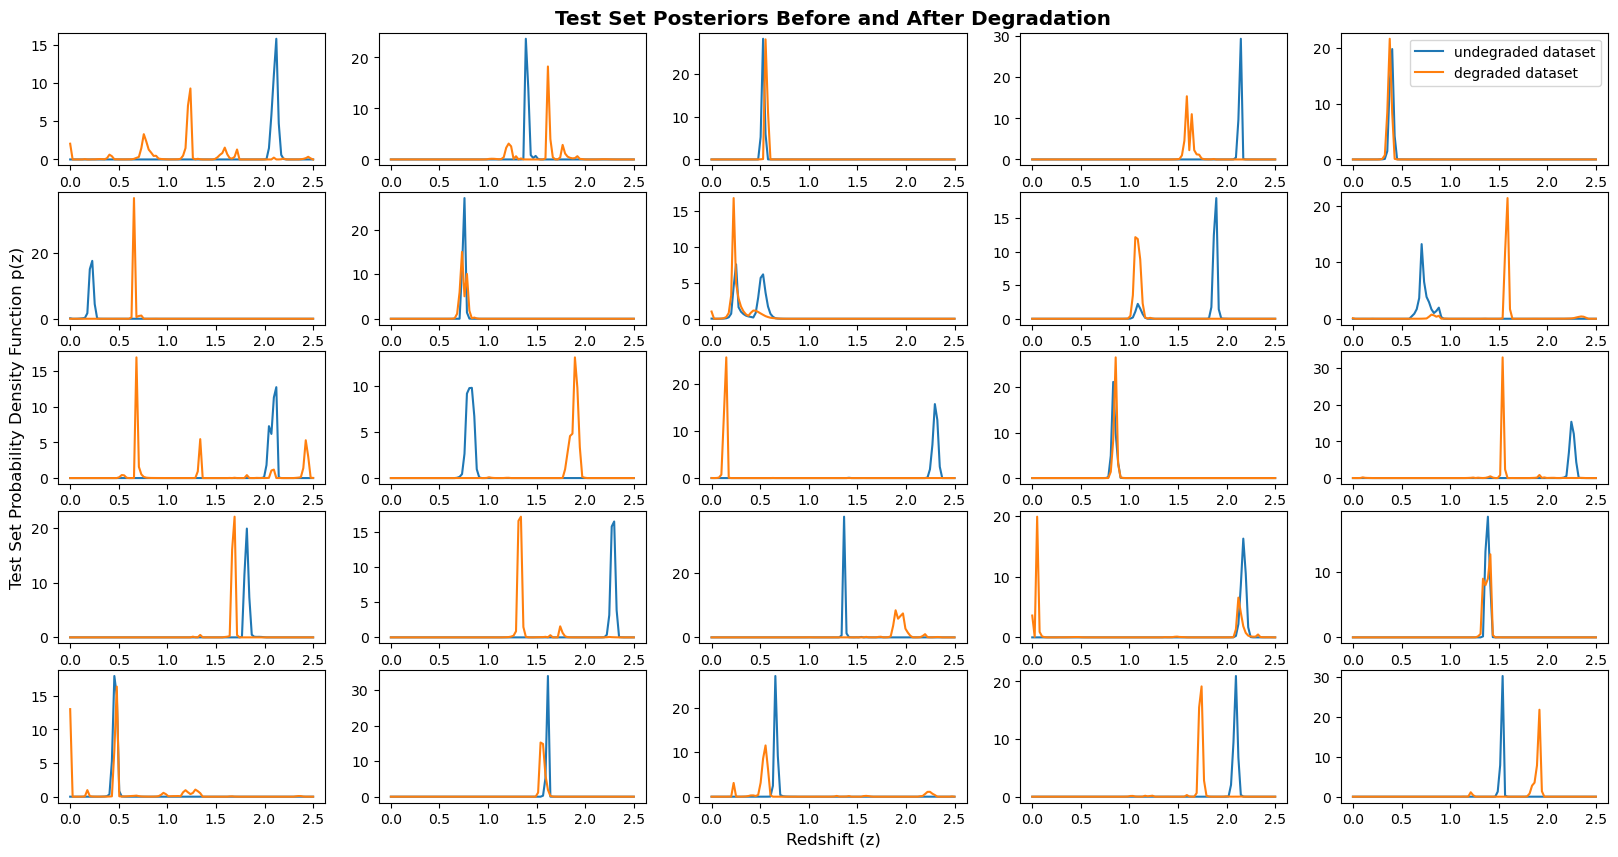

In [259]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (20, 10)) 

ct = 0
for i in range(0, 5):
    for j in range(0, 5):
        axes[i][j].plot(orig_test_xvals[0], orig_test_yvals[ct], label = 'undegraded dataset')
        axes[i][j].plot(deg_test_xvals[0], deg_test_yvals[ct], label = 'degraded dataset')
        ct += 1
axes[2][0].set_ylabel("Test Set Probability Density Function p(z)", fontsize = 'large')
axes[4][2].set_xlabel("Redshift (z)", fontsize = 'large')
axes[0][2].set_title("Test Set Posteriors Before and After Degradation", fontsize = 'x-large', fontweight = 'bold')
handles, labels = axes[0][4].get_legend_handles_labels()
axes[0][4].legend(handles, labels)

# Tables

In [220]:
#stages for making tables 
col_remapper = ColumnMapper.make_stage(
    name='col_remapper', 
    columns=rename_dict,
)
   
table_conv = TableConverter.make_stage(
    name='table_conv', 
    output_format='numpyDict',
)

In [10]:
type(orig_train_data)

rail.core.data.PqHandle

In [221]:
#actually make the tables: 

#un-degraded training data 
orig_train_data_pq = col_remapper(orig_train_data)
table_1_data = table_conv(orig_train_data_pq)

table_1 = tables_io.convertObj(table_1_data.data, tables_io.types.PD_DATAFRAME)
table_1

Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper
Inserting handle into data store.  output_table_conv: inprogress_output_table_conv.hdf5, table_conv


redshift  mag_u_lsst  mag_g_lsst  mag_r_lsst  mag_i_lsst  mag_z_lsst  \
0     0.366041   25.910597   25.005802   24.120304   23.872282   23.624046   
1     1.309581   26.433891   26.215755   26.078932   25.774639   25.273895   
2     0.485092   23.466496   23.015490   22.125854   21.753710   21.629732   
3     1.511789   27.014959   26.777920   26.608171   26.148266   25.836603   
4     1.995296   26.689100   26.287848   25.892471   25.669477   25.322496   
...        ...         ...         ...         ...         ...         ...   
9995  0.165731   26.995617   26.222031   25.828409   25.547272   25.539665   
9996  0.325223   22.868736   21.454208   20.270374   19.816101   19.607658   
9997  0.914982   28.368198   27.975056   27.246788   26.381451   25.900368   
9998  0.888838   27.927502   27.130405   26.459896   25.790058   25.504095   
9999  0.616364   26.688015   26.442568   25.837685   25.511101   25.642588   

      mag_y_lsst  mag_err_u_lsst  mag_err_g_lsst  mag_err_r_lsst  \
0      23.555634             NaN             NaN             NaN   
1      24.823082             NaN             NaN             NaN   
2      21.311659             NaN             NaN             NaN   
3      25.278090             NaN             NaN             NaN   
4      25.115894             NaN             NaN             NaN   
...          ...             ...             ...             ...   
9995   25.464390             NaN             NaN             NaN   
9996   19.411228             NaN             NaN             NaN   
9997   35.600597             NaN             NaN             NaN   
9998   25.419998             NaN             NaN             NaN   
9999   25.545670             NaN             NaN             NaN   

      mag_err_i_lsst  mag_err_z_lsst  mag_err_y_lsst  
0                NaN             NaN             NaN  
1                NaN             NaN             NaN  
2                NaN             NaN             NaN  
3                NaN             NaN             NaN  
4                NaN             NaN             NaN  
...              ...             ...             ...  
9995             NaN             NaN             NaN  
9996             NaN             NaN             NaN  
9997             NaN             NaN             NaN  
9998             NaN             NaN             NaN  
9999             NaN             NaN             NaN  

[10000 rows x 13 columns]

In [222]:
#degraded training data 
deg_train_data_pq = col_remapper(deg_train_data)
table_2_data = table_conv(deg_train_data_pq)

table_2 = tables_io.convertObj(table_2_data.data, tables_io.types.PD_DATAFRAME)
table_2

Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper
Inserting handle into data store.  output_table_conv: inprogress_output_table_conv.hdf5, table_conv


redshift  mag_u_lsst  mag_g_lsst  mag_r_lsst  mag_i_lsst  mag_z_lsst  \
0     0.366041   25.910597   25.005802   24.120304   23.872282   23.624046   
1     1.309581   26.433891   26.215755   26.078932   25.774639   25.273895   
2     0.485092   23.466496   23.015490   22.125854   21.753710   21.629732   
3     1.995296   26.689100   26.287848   25.892471   25.669477   25.322496   
4     0.994316   26.928337   26.532537   25.818542   25.011993   24.367926   
...        ...         ...         ...         ...         ...         ...   
8310  0.165731   26.995617   26.222031   25.828409   25.547272   25.539665   
8311  0.325223   22.868736   21.454208   20.270374   19.816101   19.607658   
8312  0.914982   28.368198   27.975056   27.246788   26.381451   25.900368   
8313  0.888838   27.927502   27.130405   26.459896   25.790058   25.504095   
8314  0.616364   26.688015   26.442568   25.837685   25.511101   25.642588   

      mag_y_lsst  mag_err_u_lsst  mag_err_g_lsst  mag_err_r_lsst  \
0      23.555634             NaN             NaN             NaN   
1      24.823082             NaN             NaN             NaN   
2      21.311659             NaN             NaN             NaN   
3      25.115894             NaN             NaN             NaN   
4      24.141846             NaN             NaN             NaN   
...          ...             ...             ...             ...   
8310   25.464390             NaN             NaN             NaN   
8311   19.411228             NaN             NaN             NaN   
8312   35.600597             NaN             NaN             NaN   
8313   25.419998             NaN             NaN             NaN   
8314   25.545670             NaN             NaN             NaN   

      mag_err_i_lsst  mag_err_z_lsst  mag_err_y_lsst  
0                NaN             NaN             NaN  
1                NaN             NaN             NaN  
2                NaN             NaN             NaN  
3                NaN             NaN             NaN  
4                NaN             NaN             NaN  
...              ...             ...             ...  
8310             NaN             NaN             NaN  
8311             NaN             NaN             NaN  
8312             NaN             NaN             NaN  
8313             NaN             NaN             NaN  
8314             NaN             NaN             NaN  

[8315 rows x 13 columns]

In [86]:
#test tables: (note; these will not run without running the above cell that defines the table-making stages)

#un-degraded test data 
orig_test_data_pq = col_remapper(orig_test_data)
table_3_data = table_conv(orig_test_data_pq)

table_3 = tables_io.convertObj(table_3_data.data, tables_io.types.PD_DATAFRAME)
table_3

Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper
Inserting handle into data store.  output_table_conv: inprogress_output_table_conv.hdf5, table_conv


redshift  mag_u_lsst  mag_g_lsst  mag_r_lsst  mag_i_lsst  mag_z_lsst  \
0      2.077412   28.090105   27.365177   26.823650   26.553337   26.083263   
1      1.404113   26.977442   26.524647   26.206190   25.734724   25.448801   
2      0.555326   28.497164   27.369028   25.573374   25.084757   24.867928   
3      2.138225   30.168440   29.187902   28.258026   27.707214   26.842533   
4      0.380016   25.066370   24.519159   23.829018   23.696468   23.538467   
...         ...         ...         ...         ...         ...         ...   
99995  1.264513   25.351233   25.182377   24.963123   24.591217   24.107729   
99996  0.617008   25.660681   25.184656   24.423256   23.959301   23.923279   
99997  1.116847   29.040617   28.253326   27.325447   26.464437   25.559174   
99998  1.614234   26.920584   26.598713   26.288570   25.837122   25.528473   
99999  1.069737   28.829723   28.126381   27.230125   26.505911   25.748137   

       mag_y_lsst  
0       25.655624  
1       24.836210  
2       24.571636  
3       26.028620  
4       23.432281  
...           ...  
99995   23.600878  
99996   23.737198  
99997   25.244146  
99998   25.133419  
99999   25.522871  

[100000 rows x 7 columns]

In [87]:
#degraded test data 
deg_test_data_pq = col_remapper(deg_test_data)
table_4_data = table_conv(deg_test_data_pq)

table_4 = tables_io.convertObj(table_4_data.data, tables_io.types.PD_DATAFRAME)
table_4

Inserting handle into data store.  output_col_remapper: inprogress_output_col_remapper.pq, col_remapper
Inserting handle into data store.  output_table_conv: inprogress_output_table_conv.hdf5, table_conv


redshift  mag_u_lsst  mag_err_u_lsst  mag_g_lsst  mag_err_g_lsst  \
0      2.077412   27.504806        0.620250   27.498078        0.234538   
1      1.404113   26.745607        0.352275   26.410922        0.092441   
2      0.555326   27.352924        0.556805   27.566407        0.248133   
3      2.138225   29.582530        1.984189   27.732038        0.284038   
4      0.380016   24.977200        0.079401   24.531714        0.017882   
...         ...         ...             ...         ...             ...   
99995  1.264513   25.558484        0.131694   25.178159        0.031117   
99996  0.617008   25.662697        0.144036   25.158522        0.030586   
99997  1.116847   27.211551        0.502337   28.159295        0.398193   
99998  1.614234   26.515510        0.293365   26.675644        0.116504   
99999  1.069737   27.506961        0.621187   29.206328        0.836943   

       mag_r_lsst  mag_err_r_lsst  mag_i_lsst  mag_err_i_lsst  mag_z_lsst  \
0       26.894143        0.138563   26.740775        0.177658   26.369678   
1       26.172050        0.073664   25.713053        0.072683   25.418181   
2       25.527015        0.041569   25.091433        0.041874   24.871376   
3       28.296270        0.436201   27.913500        0.456779   26.702099   
4       23.841206        0.010309   23.710189        0.012950   23.539599   
...           ...             ...         ...             ...         ...   
99995   24.990926        0.025930   24.595810        0.027055   24.098086   
99996   24.435017        0.016186   23.935889        0.015474   23.975465   
99997   27.475856        0.226865   26.498688        0.144461   25.465905   
99998   26.266483        0.080073   25.940042        0.088800   25.492804   
99999   27.389104        0.211047   26.449833        0.138507   25.909276   

       mag_err_z_lsst  mag_y_lsst  mag_err_y_lsst  
0            0.222602   26.266808        0.430675  
1            0.098475   24.854168        0.135345  
2            0.060775   24.717210        0.120202  
3            0.292322   25.673211        0.269657  
4            0.018929   23.514518        0.041588  
...               ...         ...             ...  
99995        0.030645   23.633527        0.046218  
99996        0.027524   23.766907        0.052027  
99997        0.102679   25.345340        0.205632  
99998        0.105123   25.454279        0.225199  
99999        0.150819   25.911176        0.326594  

[100000 rows x 13 columns]

# Informative Plots :) 

In [10]:
import matplotlib.pyplot as plt
#import corner.py

## Training Set


In [223]:
# undegraded training data, band as a function of redshift 

data_1 = np.asarray(table_1)

redshift_1 = data_1[:,0]
u_1 = data_1[:, 1]
g_1 = data_1[:, 2]
r_1 = data_1[:, 3]
i_1 = data_1[:, 4]
z_1 = data_1[:, 5]
y_1 = data_1[:, 6]

# degraded training data, band as a function of redshift 

data_2 = np.asarray(table_2)

redshift_2 = data_2[:,0]
u_2 = data_2[:, 1]
g_2 = data_2[:, 2]
r_2 = data_2[:, 3]
i_2 = data_2[:, 4]
z_2 = data_2[:, 5]
y_2 = data_2[:, 6]



(15.0, 35.0)

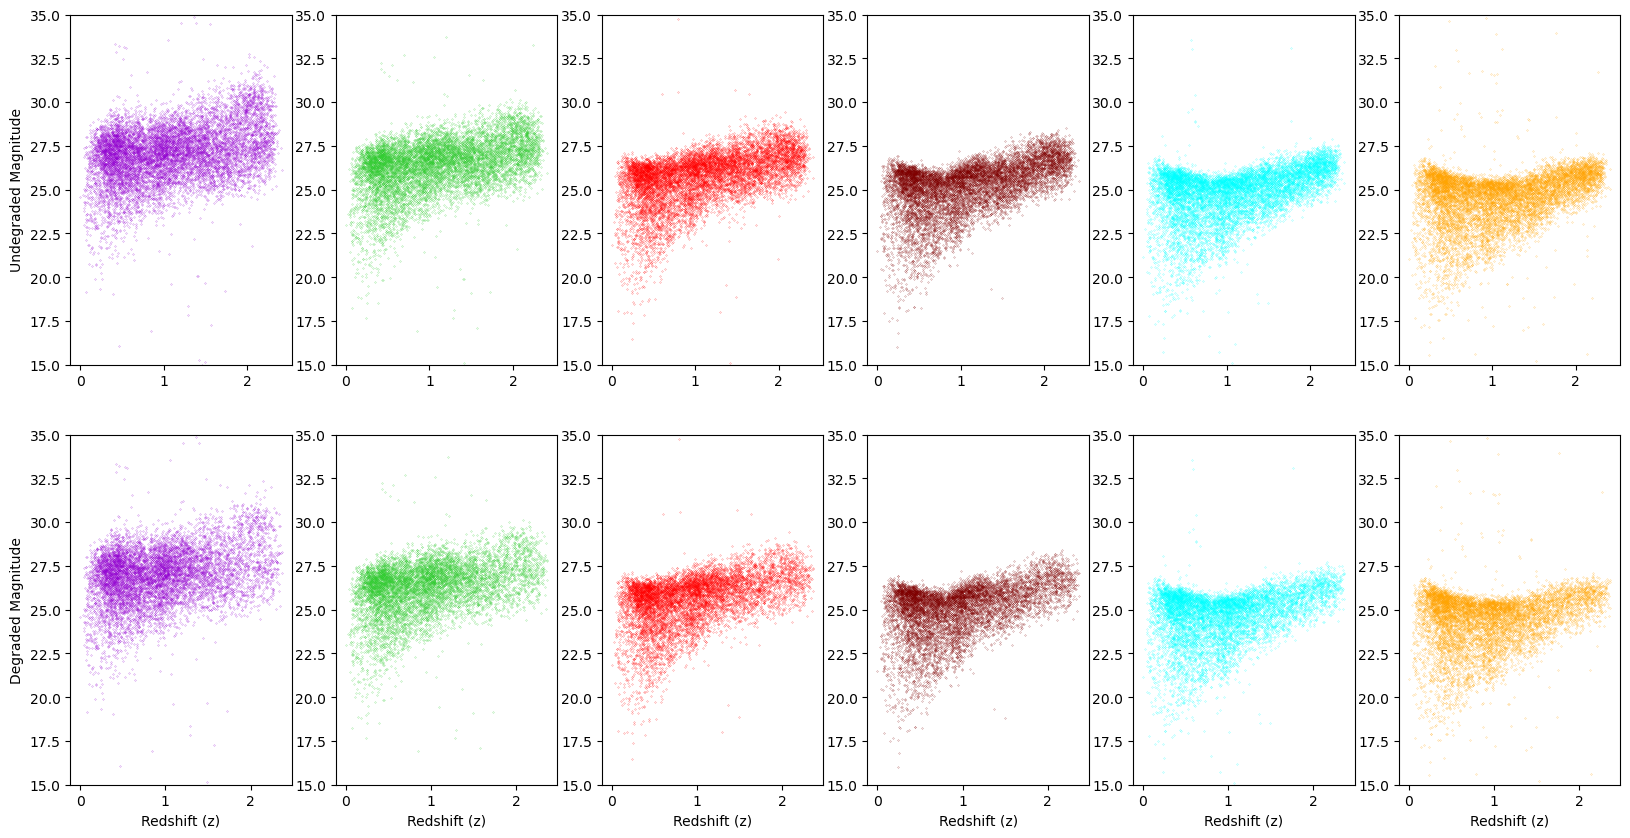

In [98]:

fig, axes = plt.subplots(nrows = 2, ncols = 6, figsize = (20, 10))
axes[0][0].scatter(redshift_1, u_1, c="darkviolet", marker=".", s=.1)
axes[0][0].set_ylabel('Undegraded Magnitude')
axes[0][0].set_ylim(ymin=15, ymax=35)
axes[0][1].scatter(redshift_1, g_1, c="limegreen", marker=".", s=.1)
axes[0][1].set_ylim(ymin=15, ymax=35)
axes[0][2].scatter(redshift_1, r_1, c="red", marker=".", s=.1)
axes[0][2].set_ylim(ymin=15, ymax=35)
axes[0][3].scatter(redshift_1, i_1, c="maroon", marker=".", s=.1)
axes[0][3].set_ylim(ymin=15, ymax=35)
axes[0][4].scatter(redshift_1, z_1, c="cyan", marker=".", s=.1)
axes[0][4].set_ylim(ymin=15, ymax=35)
axes[0][5].scatter(redshift_1, y_1, c="orange", marker=".", s=.1)
axes[0][5].set_ylim(ymin=15, ymax=35)

axes[1][0].scatter(redshift_2, u_2, c="darkviolet", marker=".", s=.1)
axes[1][0].set_xlabel('Redshift (z)')
axes[1][0].set_ylabel('Degraded Magnitude')
axes[1][0].set_ylim(ymin=15, ymax=35)
axes[1][1].scatter(redshift_2, g_2, c="limegreen", marker=".", s=.1)
axes[1][1].set_xlabel('Redshift (z)')
axes[1][1].set_ylim(ymin=15, ymax=35)
axes[1][2].scatter(redshift_2, r_2, c="red", marker=".", s=.1)
axes[1][2].set_xlabel('Redshift (z)')
axes[1][2].set_ylim(ymin=15, ymax=35)
axes[1][3].scatter(redshift_2, i_2, c="maroon", marker=".", s=.1)
axes[1][3].set_xlabel('Redshift (z)')
axes[1][3].set_ylim(ymin=15, ymax=35)
axes[1][4].scatter(redshift_2, z_2, c="cyan", marker=".", s=.1)
axes[1][4].set_xlabel('Redshift (z)')
axes[1][4].set_ylim(ymin=15, ymax=35)
axes[1][5].scatter(redshift_2, y_2, c="orange", marker=".", s=.1)
axes[1][5].set_xlabel('Redshift (z)')
axes[1][5].set_ylim(ymin=15, ymax=35)

### 2D Hist 

(15.0, 35.0)

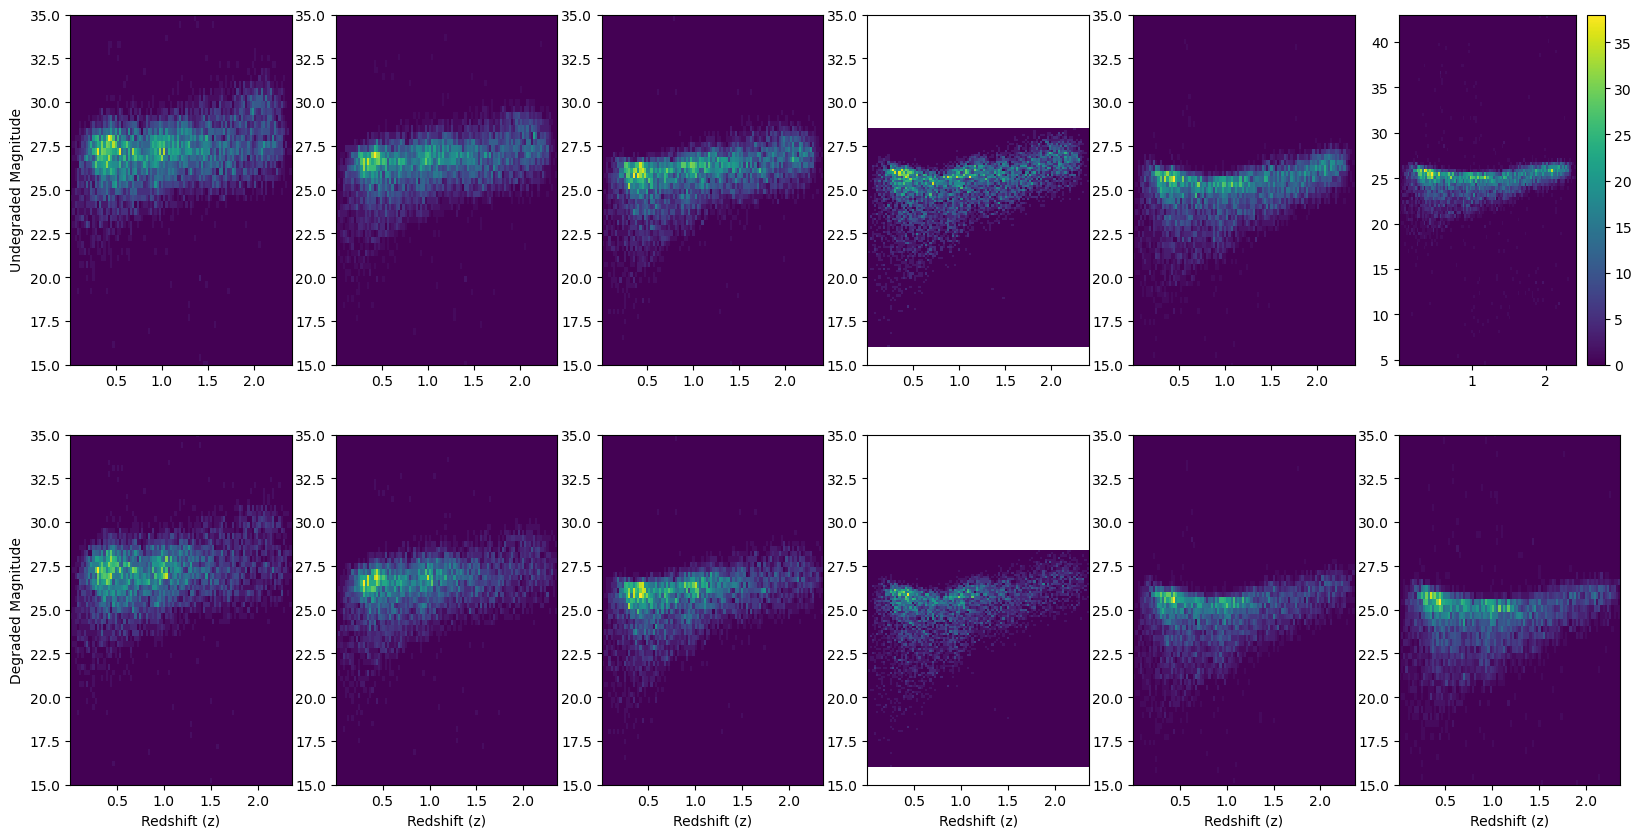

In [65]:
# 2d hists showing density before degradation 

fig, axes = plt.subplots(nrows=2, ncols = 6, figsize = (20, 10))
axes[0][0].hist2d(redshift_1, u_1, bins=100)
axes[0][0].set_ylabel('Undegraded Magnitude')
axes[0][0].set_ylim(ymin=15, ymax=35)
axes[0][1].hist2d(redshift_1, g_1, bins=100)
axes[0][1].set_ylim(ymin=15, ymax=35)
axes[0][2].hist2d(redshift_1, r_1, bins=100)
axes[0][2].set_ylim(ymin=15, ymax=35)
axes[0][3].hist2d(redshift_1, i_1, bins=100)
axes[0][3].set_ylim(ymin=15, ymax=35)
axes[0][4].hist2d(redshift_1, z_1, bins=100)
axes[0][4].set_ylim(ymin=15, ymax=35)
axes[0][5].hist2d(redshift_1, y_1, bins=100)
axes[0][5].set_ylim(ymin=15, ymax=35)

hist = axes[0][5].hist2d(redshift_1, y_1, bins=100)
fig.colorbar(hist[3], ax=axes[0][5])


axes[1][0].hist2d(redshift_2, u_2, bins=100)
axes[1][0].set_xlabel('Redshift (z)')
axes[1][0].set_ylabel('Degraded Magnitude')
axes[1][0].set_ylim(ymin=15, ymax=35)
axes[1][1].hist2d(redshift_2, g_2, bins=100)
axes[1][1].set_xlabel('Redshift (z)')
axes[1][1].set_ylim(ymin=15, ymax=35)
axes[1][2].hist2d(redshift_2, r_2, bins=100)
axes[1][2].set_xlabel('Redshift (z)')
axes[1][2].set_ylim(ymin=15, ymax=35)
axes[1][3].hist2d(redshift_2, i_2, bins=100)
axes[1][3].set_xlabel('Redshift (z)')
axes[1][3].set_ylim(ymin=15, ymax=35)
axes[1][4].hist2d(redshift_2, z_2, bins=100)
axes[1][4].set_xlabel('Redshift (z)')
axes[1][4].set_ylim(ymin=15, ymax=35)
axes[1][5].hist2d(redshift_2, y_2, bins=100)
axes[1][5].set_xlabel('Redshift (z)')
axes[1][5].set_ylim(ymin=15, ymax=35)

### Yellow Dots

In [66]:
# first we figure out how to do what we want with test cases 


ls_1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
ls_2 = [2, 4, 5, 7, 8, 9, 11, 12, 14, 15, 17, 18, 22]

end = ls_2[-1]
stop = ls_1.index(end)

for i in range(0, stop):
    if ls_1[i] != ls_2[i]:
        ls_2.insert(i, 100)

diff = len(ls_1) - len(ls_2)
for i in range(1, diff+1): 
    ls_2.insert(stop+i, 100)
        
print(ls_2)

# success

[100, 2, 100, 4, 5, 100, 7, 8, 9, 100, 11, 12, 100, 14, 15, 100, 17, 18, 100, 100, 100, 22]


In [ ]:
# How to make the yellow dots

In [67]:
# now we do it with our real data: 

# for u: 

u_ls_1 = u_1.tolist()
u_ls_2 = u_2.tolist()

end = u_ls_2[-1]
stop = u_ls_1.index(end)

for i in range(0, stop):
    if u_ls_1[i] != u_ls_2[i]:
        u_ls_2.insert(i, 100)

diff = len(u_ls_1) - len(u_ls_2)
for i in range(1, diff+1): 
    u_ls_2.insert(stop+i, 100)

u_ls_s = []
for i in range(len(u_ls_1)):
    if u_ls_2[i] == 100:
        u_ls_s.append(u_ls_1[i])
u_2_s = np.asarray(u_ls_s)

u_ls_r = []
for i in range(len(u_ls_2)):
    if u_ls_2[i] == 100:
        u_ls_r.append(redshift_1[i])
u_redshift_s = np.asarray(u_ls_r)


In [68]:
# for g:

g_ls_1 = g_1.tolist()
g_ls_2 = g_2.tolist()

end = g_ls_2[-1]
stop = g_ls_1.index(end)

for i in range(0, stop):
    if g_ls_1[i] != g_ls_2[i]:
        g_ls_2.insert(i, 100)

diff = len(g_ls_1) - len(g_ls_2)
for i in range(1, diff+1): 
    g_ls_2.insert(stop+i, 100)

g_ls_s = []
for i in range(len(g_ls_1)):
    if g_ls_2[i] == 100:
        g_ls_s.append(g_ls_1[i])
g_2_s = np.asarray(g_ls_s)

g_ls_r = []
for i in range(len(g_ls_2)):
    if g_ls_2[i] == 100:
        g_ls_r.append(redshift_1[i])
g_redshift_s = np.asarray(g_ls_r)

In [69]:
# for r:

r_ls_1 = r_1.tolist()
r_ls_2 = r_2.tolist()

end = r_ls_2[-1]
stop = r_ls_1.index(end)

for i in range(0, stop):
    if r_ls_1[i] != r_ls_2[i]:
        r_ls_2.insert(i, 100)

diff = len(r_ls_1) - len(r_ls_2)
for i in range(1, diff+1): 
    r_ls_2.insert(stop+i, 100)

r_ls_s = []
for i in range(len(r_ls_1)):
    if r_ls_2[i] == 100:
        r_ls_s.append(r_ls_1[i])
r_2_s = np.asarray(r_ls_s)

r_ls_r = []
for i in range(len(r_ls_2)):
    if r_ls_2[i] == 100:
        r_ls_r.append(redshift_1[i])
r_redshift_s = np.asarray(r_ls_r)

In [70]:
# for i:

i_ls_1 = i_1.tolist()
i_ls_2 = i_2.tolist()

end = i_ls_2[-1]
stop = i_ls_1.index(end)

for i in range(0, stop):
    if i_ls_1[i] != i_ls_2[i]:
        i_ls_2.insert(i, 100)

diff = len(i_ls_1) - len(i_ls_2)
for i in range(1, diff+1): 
    i_ls_2.insert(stop+i, 100)

i_ls_s = []
for i in range(len(i_ls_1)):
    if i_ls_2[i] == 100:
        i_ls_s.append(i_ls_1[i])
i_2_s = np.asarray(i_ls_s)

i_ls_r = []
for i in range(len(i_ls_2)):
    if i_ls_2[i] == 100:
        i_ls_r.append(redshift_1[i])
i_redshift_s = np.asarray(i_ls_r)

In [71]:
# for z: 

z_ls_1 = z_1.tolist()
z_ls_2 = z_2.tolist()

end = z_ls_2[-1]
stop = z_ls_1.index(end)

for i in range(0, stop):
    if z_ls_1[i] != z_ls_2[i]:
        z_ls_2.insert(i, 100)

diff = len(z_ls_1) - len(z_ls_2)
for i in range(1, diff+1): 
    z_ls_2.insert(stop+i, 100)

z_ls_s = []
for i in range(len(z_ls_1)):
    if z_ls_2[i] == 100:
        z_ls_s.append(z_ls_1[i])
z_2_s = np.asarray(z_ls_s)

z_ls_r = []
for i in range(len(z_ls_2)):
    if z_ls_2[i] == 100:
        z_ls_r.append(redshift_1[i])
z_redshift_s = np.asarray(z_ls_r)

In [72]:
# for y:

y_ls_1 = y_1.tolist()
y_ls_2 = y_2.tolist()

end = y_ls_2[-1]
stop = y_ls_1.index(end)

for i in range(0, stop):
    if y_ls_1[i] != y_ls_2[i]:
        y_ls_2.insert(i, 100)

diff = len(y_ls_1) - len(y_ls_2)
for i in range(1, diff+1): 
    y_ls_2.insert(stop+i, 100)

y_ls_s = []
for i in range(len(y_ls_1)):
    if y_ls_2[i] == 100:
        y_ls_s.append(y_ls_1[i])
y_2_s = np.asarray(y_ls_s)

y_ls_r = []
for i in range(len(y_ls_2)):
    if y_ls_2[i] == 100:
        y_ls_r.append(redshift_1[i])
y_redshift_s = np.asarray(y_ls_r)

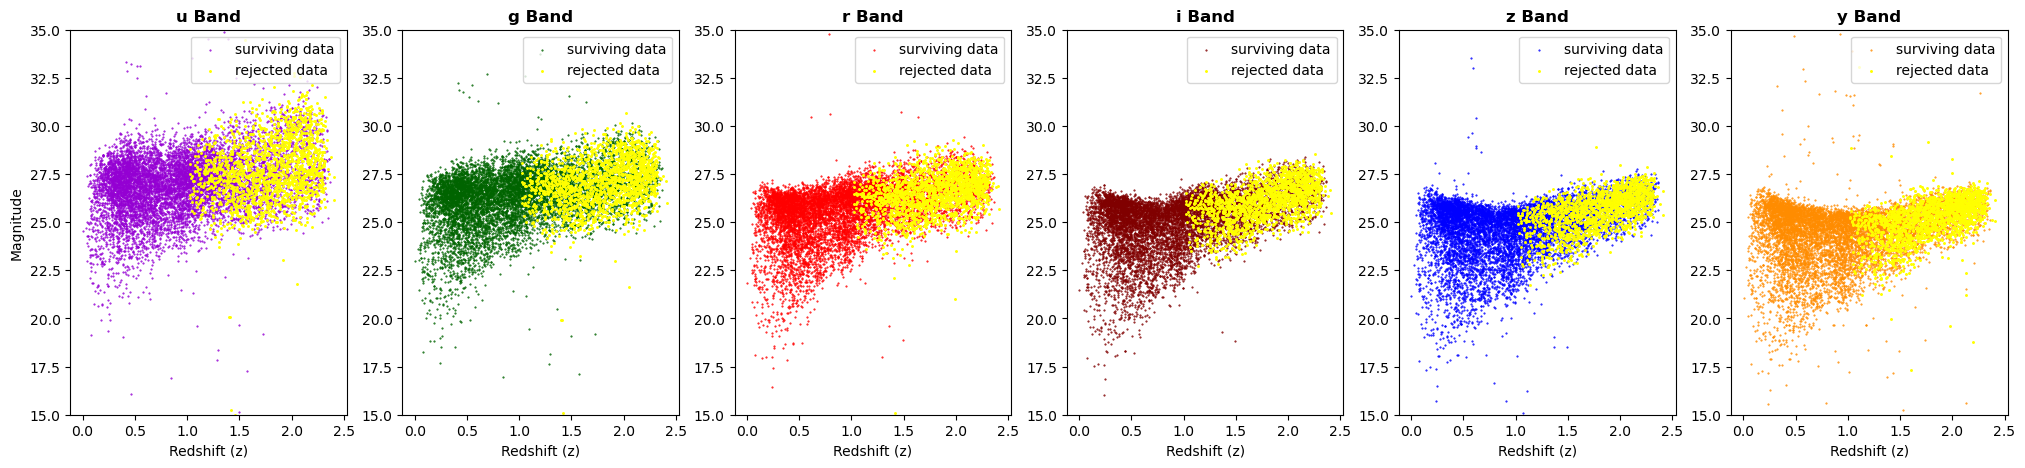

In [148]:
# the bright yellow dots show the data points that were deleted by the degrader 

fig, axes = plt.subplots(ncols = 6, figsize = (25, 5)) 

plt1 = axes[0].scatter(redshift_2, u_2, c="darkviolet", marker=".", s=1)
dots1 = axes[0].scatter(u_redshift_s, u_2_s, c="yellow", marker=".", s=5)
axes[0].set_xlabel('Redshift (z)')
axes[0].set_ylabel('Magnitude')
axes[0].set_ylim(ymin=15, ymax=35)
axes[0].set_title('u Band', fontweight = 'bold')
axes[0].legend([plt1, dots1], ['surviving data', 'rejected data'], loc = 'upper right')
plt2 = axes[1].scatter(redshift_2, g_2, c="darkgreen", marker=".", s=1)
dots2 = axes[1].scatter(g_redshift_s, g_2_s, c="yellow", marker=".", s=5)
axes[1].set_xlabel('Redshift (z)')
axes[1].set_ylim(ymin=15, ymax=35)
axes[1].set_title('g Band', fontweight = 'bold')
axes[1].legend([plt2, dots2], ['surviving data', 'rejected data'], loc = 'upper right')
plt3 = axes[2].scatter(redshift_2, r_2, c="red", marker=".", s=1)
dots3 = axes[2].scatter(r_redshift_s, r_2_s, c="yellow", marker=".", s=5)
axes[2].set_xlabel('Redshift (z)')
axes[2].set_ylim(ymin=15, ymax=35)
axes[2].set_title('r Band', fontweight = 'bold')
axes[2].legend([plt3, dots3], ['surviving data', 'rejected data'], loc = 'upper right')
plt4 = axes[3].scatter(redshift_2, i_2, c="maroon", marker=".", s=1)
dots4 = axes[3].scatter(i_redshift_s, i_2_s, c="yellow", marker=".", s=5)
axes[3].set_xlabel('Redshift (z)')
axes[3].set_ylim(ymin=15, ymax=35)
axes[3].set_title('i Band', fontweight = 'bold')
axes[3].legend([plt4, dots4], ['surviving data', 'rejected data'], loc = 'upper right')
plt5 = axes[4].scatter(redshift_2, z_2, c="blue", marker=".", s=1)
dots5 = axes[4].scatter(z_redshift_s, z_2_s, c="yellow", marker=".", s=5)
axes[4].set_xlabel('Redshift (z)')
axes[4].set_ylim(ymin=15, ymax=35)
axes[4].set_title('z Band', fontweight = 'bold')
axes[4].legend([plt5, dots5], ['surviving data', 'rejected data'], loc = 'upper right')
plt6 = axes[5].scatter(redshift_2, y_2, c="darkorange", marker=".", s=1)
dots6 = axes[5].scatter(y_redshift_s, y_2_s, c="yellow", marker=".", s=5)
axes[5].set_xlabel('Redshift (z)')
axes[5].set_ylim(ymin=15, ymax=35)
axes[5].set_title('y Band', fontweight = 'bold')
axes[5].legend([plt6, dots6], ['surviving data', 'rejected data'], loc = 'upper right')
#axes[5].legend([plt1, plt2, plt3, plt4, plt5, plt6, dots], ['u band', 'g band', 'r band', 'i band', 'z band', 'y band', 'rejected data'])

## Test Set 

In [89]:
# undegraded test data, band as a function of redshift 

data_3 = np.asarray(table_3)

redshift_3 = data_3[:,0]
u_3 = data_3[:, 1]
g_3 = data_3[:, 2]
r_3 = data_3[:, 3]
i_3 = data_3[:, 4]
z_3 = data_3[:, 5]
y_3 = data_3[:, 6]


data_4 = np.asarray(table_4)

redshift_4 = data_4[:,0]
u_4 = data_4[:, 1]
g_4 = data_4[:, 3]
r_4 = data_4[:, 5]
i_4 = data_4[:, 7]
z_4 = data_4[:, 9]
y_4 = data_4[:, 11]



(5.0, 35.0)

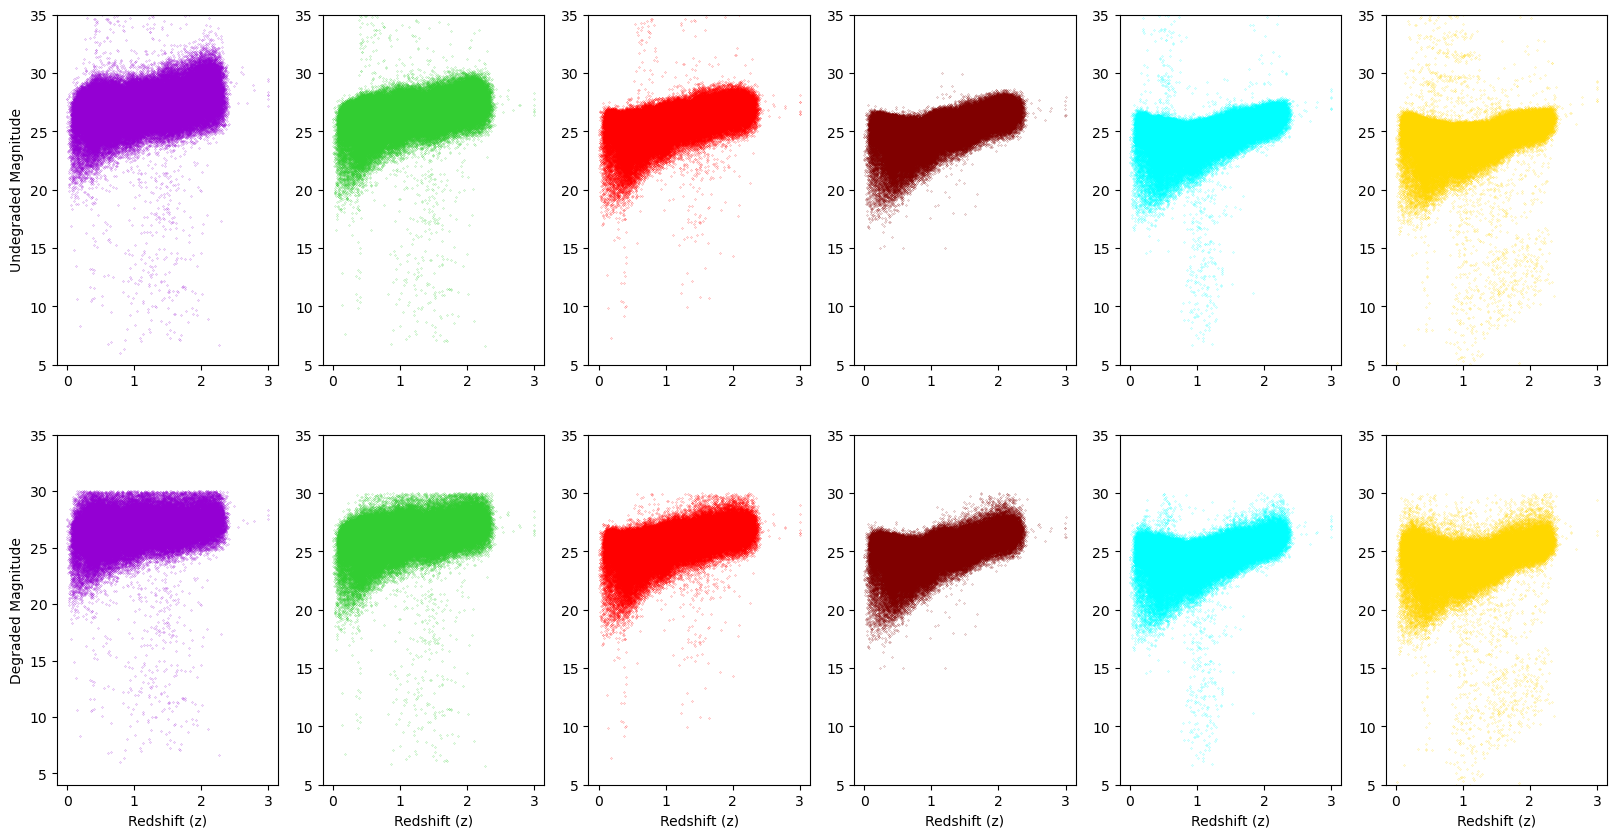

In [ ]:
# degraded test data, band as a function of redshift 


fig, axes = plt.subplots(nrows = 2, ncols = 6, figsize = (20, 10))

axes[0][0].scatter(redshift_3, u_3, c="darkviolet", marker=".", s=.1)
axes[0][0].set_ylabel('Undegraded Magnitude')
axes[0][0].set_ylim(ymin=5, ymax=35)
axes[0][1].scatter(redshift_3, g_3, c="limegreen", marker=".", s=.1)
axes[0][1].set_ylim(ymin=5, ymax=35)
axes[0][2].scatter(redshift_3, r_3, c="red", marker=".", s=.1)
axes[0][2].set_ylim(ymin=5, ymax=35)
axes[0][3].scatter(redshift_3, i_3, c="maroon", marker=".", s=.1)
axes[0][3].set_ylim(ymin=5, ymax=35)
axes[0][4].scatter(redshift_3, z_3, c="cyan", marker=".", s=.1)
axes[0][4].set_ylim(ymin=5, ymax=35)
axes[0][5].scatter(redshift_3, y_3, c="gold", marker=".", s=.1)
axes[0][5].set_ylim(ymin=5, ymax=35)



axes[1][0].scatter(redshift_4, u_4, c="darkviolet", marker=".", s=.1)
axes[1][0].set_xlabel('Redshift (z)')
axes[1][0].set_ylabel('Degraded Magnitude')
axes[1][0].set_ylim(ymin=4, ymax=35)
axes[1][1].scatter(redshift_4, g_4, c="limegreen", marker=".", s=.1)
axes[1][1].set_xlabel('Redshift (z)')
axes[1][1].set_ylim(ymin=5, ymax=35)
axes[1][2].scatter(redshift_4, r_4, c="red", marker=".", s=.1)
axes[1][2].set_xlabel('Redshift (z)')
axes[1][2].set_ylim(ymin=5, ymax=35)
axes[1][3].scatter(redshift_4, i_4, c="maroon", marker=".", s=.1)
axes[1][3].set_xlabel('Redshift (z)')
axes[1][3].set_ylim(ymin=5, ymax=35)
axes[1][4].scatter(redshift_4, z_4, c="cyan", marker=".", s=.1)
axes[1][4].set_xlabel('Redshift (z)')
axes[1][4].set_ylim(ymin=5, ymax=35)
axes[1][5].scatter(redshift_4, y_4, c="gold", marker=".", s=.1)
axes[1][5].set_xlabel('Redshift (z)')
axes[1][5].set_ylim(ymin=5, ymax=35)

# the differences in shape from the other data set is a little weird but I actually think it makes sense; since there's a factor of 10 more data points, it makes sense to see more outliers right? 

### 2D Hist

In [ ]:
idx_u = np.where(np.isfinite(u_4) == False)[0].tolist()
idx_g = np.where(np.isfinite(g_4) == False)[0].tolist()
idx_r = np.where(np.isfinite(r_4) == False)[0].tolist()
idx_i = np.where(np.isfinite(i_4) == False)[0].tolist()
idx_z = np.where(np.isfinite(z_4) == False)[0].tolist()
idx_y = np.where(np.isfinite(y_4) == False)[0].tolist()

ls = idx_u + idx_g + idx_r + idx_i + idx_z + idx_y
ls = list(dict.fromkeys(ls))
idx = np.asarray(ls)
np.sort(idx)
print(idx)

[    6    11    14 ... 98979 99517 99640]


In [ ]:
tmp_redshift = redshift_4
for i in range(len(tmp_redshift)):
    if i in idx:
        tmp_redshift[i] = 0
ls_redshift = []
for i in tmp_redshift:
    if i != 0:
        ls_redshift.append(i)
cleaned_redshift = np.asarray(ls_redshift)

tmp_u = u_4
for i in range(len(tmp_u)):
    if i in idx:
        tmp_u[i] = 0
ls_u = []
for i in tmp_u:
    if i != 0:
        ls_u.append(i)
cleaned_u = np.asarray(ls_u)

tmp_g = g_4
for i in range(len(tmp_g)):
    if i in idx:
        tmp_g[i] = 0
ls_g = []
for i in tmp_g:
    if i != 0:
        ls_g.append(i)
cleaned_g = np.asarray(ls_g)

tmp_r = r_4
for i in range(len(tmp_r)):
    if i in idx:
        tmp_r[i] = 0
ls_r = []
for i in tmp_r:
    if i != 0:
        ls_r.append(i)
cleaned_r = np.asarray(ls_r)

tmp_i = i_4
for i in range(len(tmp_i)):
    if i in idx:
        tmp_i[i] = 0
ls_i = []
for i in tmp_i:
    if i != 0:
        ls_i.append(i)
cleaned_i = np.asarray(ls_i)

tmp_z = z_4
for i in range(len(tmp_z)):
    if i in idx:
        tmp_z[i] = 0
ls_z = []
for i in tmp_z:
    if i != 0:
        ls_z.append(i)
cleaned_z = np.asarray(ls_z)

tmp_y = y_4
for i in range(len(tmp_y)):
    if i in idx:
        tmp_y[i] = 0
ls_y = []
for i in tmp_y:
    if i != 0:
        ls_y.append(i)
cleaned_y = np.asarray(ls_y)

n = 0
for i in tmp_y:
    if i == 0:
        n += 1
print(n)


15039


(15.0, 35.0)

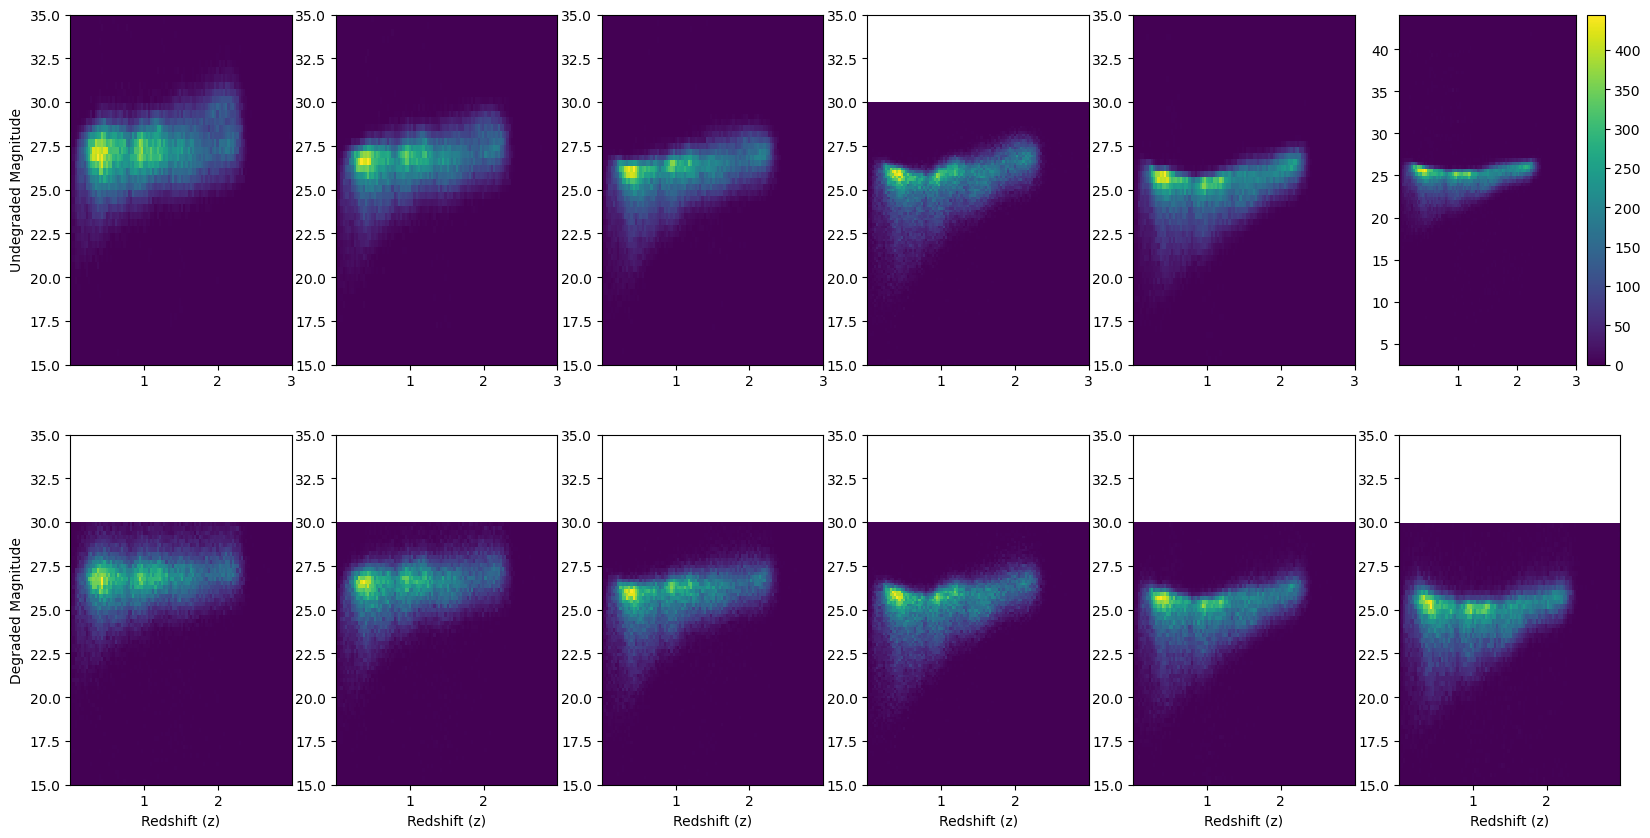

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 6, figsize = (20, 10))
axes[0][0].hist2d(redshift_3, u_3, bins=100)
axes[0][0].set_ylabel('Undegraded Magnitude')
axes[0][0].set_ylim(15, 35)
axes[0][1].hist2d(redshift_3, g_3, bins=100)
axes[0][1].set_ylim(15, 35)
axes[0][2].hist2d(redshift_3, r_3, bins=100)
axes[0][2].set_ylim(15, 35)
axes[0][3].hist2d(redshift_3, i_3, bins=100)
axes[0][3].set_ylim(15, 35)
axes[0][4].hist2d(redshift_3, z_3, bins=100)
axes[0][4].set_ylim(15, 35)
axes[0][5].hist2d(redshift_3, y_3, bins=100)
axes[0][5].set_ylim(15, 35)

hist = axes[0][5].hist2d(redshift_3, y_3, bins=100)
fig.colorbar(hist[3], ax=axes[0][5])


# Use np.isnan, np.isfinite
axes[1][0].hist2d(cleaned_redshift, cleaned_u, bins=100)
axes[1][0].set_xlabel('Redshift (z)')
axes[1][0].set_ylabel('Degraded Magnitude')
axes[1][0].set_ylim(15, 35)
axes[1][1].hist2d(cleaned_redshift, cleaned_g, bins=100)
axes[1][1].set_xlabel('Redshift (z)')
axes[1][1].set_ylim(15, 35)
axes[1][2].hist2d(cleaned_redshift, cleaned_r, bins=100)
axes[1][2].set_xlabel('Redshift (z)')
axes[1][2].set_ylim(15, 35)
axes[1][3].hist2d(cleaned_redshift, cleaned_i, bins=100)
axes[1][3].set_xlabel('Redshift (z)')
axes[1][3].set_ylim(15, 35)
axes[1][4].hist2d(cleaned_redshift, cleaned_z, bins=100)
axes[1][4].set_xlabel('Redshift (z)')
axes[1][4].set_ylim(15, 35)
axes[1][5].hist2d(cleaned_redshift, cleaned_y, bins=100)
axes[1][5].set_xlabel('Redshift (z)')
axes[1][5].set_ylim(15, 35)



### Difference Plots 

Text(0.5, 0, 'redshift')

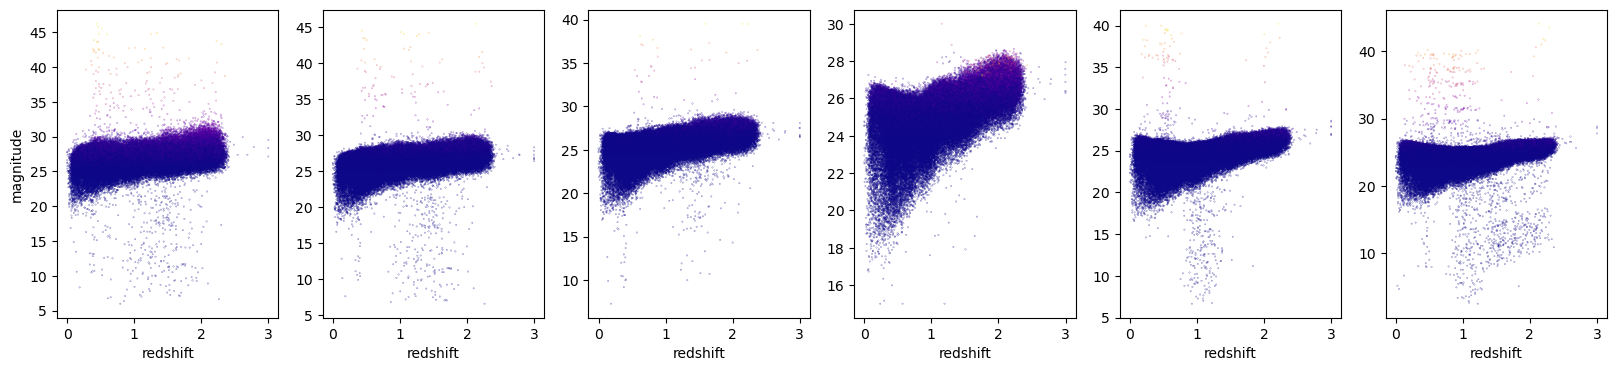

In [267]:
# this shows the data before degradation, and the color corresponds to how much the degradation changed the measured flux magnitude  

from matplotlib import cm


u_test_diff = np.abs(u_4 - u_3)
g_test_diff = np.abs(g_4 - g_3)
r_test_diff = np.abs(r_4 - r_3)
i_test_diff = np.abs(i_4 - i_3)
z_test_diff = np.abs(z_4 - z_3)
y_test_diff = np.abs(y_4 - y_3)

fig, axes = plt.subplots(ncols = 6, figsize = (20, 4))
axes[0].scatter(redshift_4, u_3, c=u_test_diff, cmap=cm.plasma, marker=".", s=.1)
axes[0].set_xlabel('redshift')
axes[0].set_ylabel('magnitude')
axes[1].scatter(redshift_4, g_3, c=g_test_diff, cmap=cm.plasma, marker=".", s=.1)
axes[1].set_xlabel('redshift')
axes[2].scatter(redshift_4, r_3, c=r_test_diff, cmap=cm.plasma, marker=".", s=.1)
axes[2].set_xlabel('redshift')
axes[3].scatter(redshift_4, i_3, c=i_test_diff, cmap=cm.plasma, marker=".", s=.1)
axes[3].set_xlabel('redshift')
axes[4].scatter(redshift_4, z_3, c=z_test_diff, cmap=cm.plasma, marker=".", s=.1)
axes[4].set_xlabel('redshift')
axes[5].scatter(redshift_4, y_3, c=y_test_diff, cmap=cm.plasma, marker=".", s=.1)
axes[5].set_xlabel('redshift')

##how do I put a colorbar on this? 

(array([7.1362e+04, 1.6210e+04, 6.0630e+03, 2.5160e+03, 1.2570e+03,
        5.7700e+02, 3.2100e+02, 1.9800e+02, 1.4600e+02, 1.0800e+02,
        7.7000e+01, 7.9000e+01, 5.7000e+01, 4.4000e+01, 3.0000e+01,
        3.6000e+01, 2.2000e+01, 2.4000e+01, 1.3000e+01, 1.4000e+01,
        1.1000e+01, 1.4000e+01, 6.0000e+00, 1.0000e+00, 5.0000e+00,
        3.0000e+00, 5.0000e+00, 3.0000e+00, 3.0000e+00, 4.0000e+00,
        2.0000e+00, 4.0000e+00, 2.0000e+00, 4.0000e+00, 2.0000e+00,
        4.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00,
        3.0000e+00, 4.0000e+00, 1.0000e+00, 4.0000e+00, 2.0000e+00,
        4.0000e+00, 2.0000e+00, 4.0000e+00, 0.0000e+00, 8.0000e+00,
        5.0000e+00, 4.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        2.0000e+00, 2.0000e+00, 6.0000e+00, 1.0000e+00, 4.0000e+00,
        2.0000e+00, 5.0000e+00, 3.0000e+00, 3.0000e+00, 5.0000e+00,
        1.0000e+00, 4.0000e+00, 5.0000e+00, 4.0000e+00, 3.0000e+00,
        2.0000e+00, 2.0000e+00, 0.0000e+00, 1.00

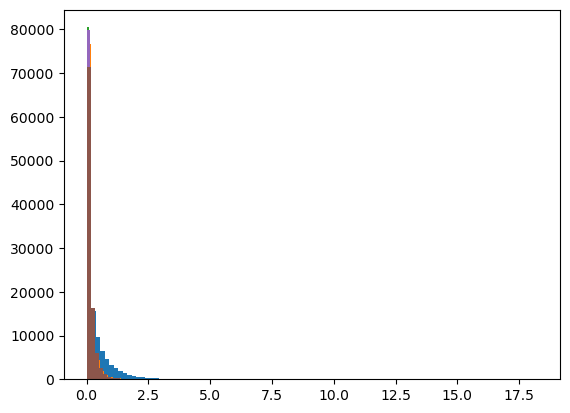

In [270]:
plt.hist(u_test_diff, bins = 100)
plt.hist(g_test_diff, bins = 100)
plt.hist(r_test_diff, bins = 100)
plt.hist(i_test_diff, bins = 100)
plt.hist(z_test_diff, bins = 100)
plt.hist(y_test_diff, bins = 100)

Text(0.5, 0, 'redshift')

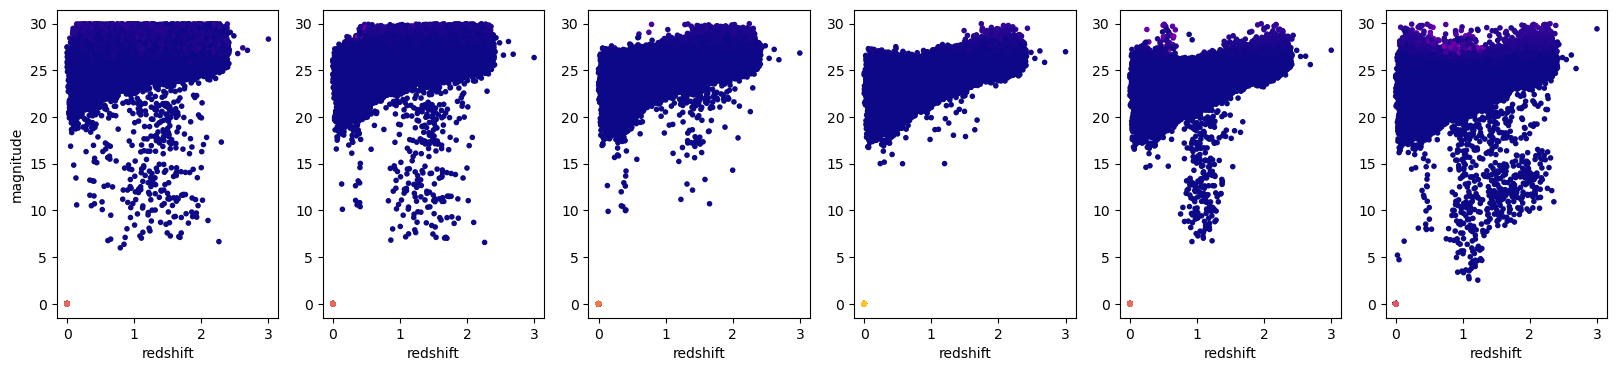

In [ ]:
fig, axes = plt.subplots(ncols = 6, figsize = (20, 4))
axes[0].scatter(redshift_4, u_4, c=u_test_diff, cmap=cm.plasma, marker=".")
axes[0].set_xlabel('redshift')
axes[0].set_ylabel('magnitude')
axes[1].scatter(redshift_4, g_4, c=g_test_diff, cmap=cm.plasma, marker=".")
axes[1].set_xlabel('redshift')
axes[2].scatter(redshift_4, r_4, c=r_test_diff, cmap=cm.plasma, marker=".")
axes[2].set_xlabel('redshift')
axes[3].scatter(redshift_4, i_4, c=i_test_diff, cmap=cm.plasma, marker=".")
axes[3].set_xlabel('redshift')
axes[4].scatter(redshift_4, z_4, c=z_test_diff, cmap=cm.plasma, marker=".")
axes[4].set_xlabel('redshift')
axes[5].scatter(redshift_4, y_4, c=y_test_diff, cmap=cm.plasma, marker=".")
axes[5].set_xlabel('redshift')

# higher magnitudes (dimmer objects) are affected more by degradation 

### Error Plots 

Text(0.5, 0, 'redshift')

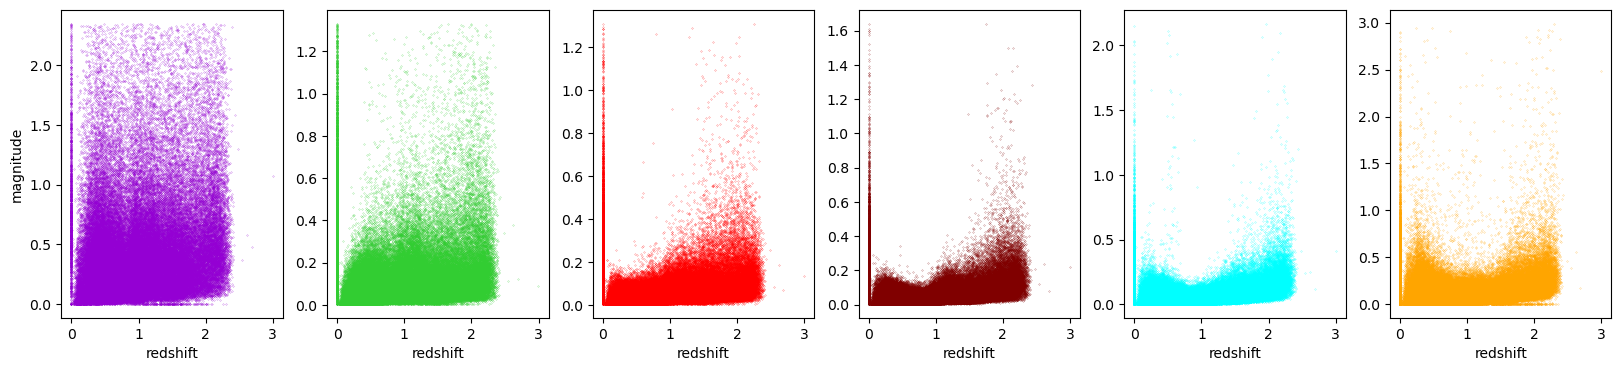

In [ ]:
# error plots: 

u_4_err = data_4[:, 2]
g_4_err = data_4[:, 4]
r_4_err = data_4[:, 6]
i_4_err = data_4[:, 8]
z_4_err = data_4[:, 10]
y_4_err = data_4[:, 12]

fig, axes = plt.subplots(ncols = 6, figsize = (20, 4))
axes[0].scatter(redshift_4, u_4_err, c="darkviolet", marker=".", s=.1)
axes[0].set_xlabel('redshift')
axes[0].set_ylabel('magnitude')
axes[1].scatter(redshift_4, g_4_err, c="limegreen", marker=".", s=.1)
axes[1].set_xlabel('redshift')
axes[2].scatter(redshift_4, r_4_err, c="red", marker=".", s=.1)
axes[2].set_xlabel('redshift')
axes[3].scatter(redshift_4, i_4_err, c="maroon", marker=".", s=.1)
axes[3].set_xlabel('redshift')
axes[4].scatter(redshift_4, z_4_err, c="cyan", marker=".", s=.1)
axes[4].set_xlabel('redshift')
axes[5].scatter(redshift_4, y_4_err, c="orange", marker=".", s=.1)
axes[5].set_xlabel('redshift')

# overall trend is that higher redshifts produce higher error (makes sense), but there are some bumps at very low redshift too 

In [ ]:
idx_u_err = np.where(np.isfinite(u_4_err) == False)[0].tolist()
idx_g_err = np.where(np.isfinite(g_4_err) == False)[0].tolist()
idx_r_err = np.where(np.isfinite(r_4_err) == False)[0].tolist()
idx_i_err = np.where(np.isfinite(i_4_err) == False)[0].tolist()
idx_z_err = np.where(np.isfinite(z_4_err) == False)[0].tolist()
idx_y_err = np.where(np.isfinite(y_4_err) == False)[0].tolist()

ls_err = idx_u_err + idx_g_err + idx_r_err + idx_i_err + idx_z_err + idx_y_err
ls_err = list(dict.fromkeys(ls_err))
idx_err = np.asarray(ls_err)
np.sort(idx_err)
print(idx_err)

[    6    11    14 ... 98979 99517 99640]


In [ ]:
tmp_redshift_err = redshift_4
for i in range(len(tmp_redshift_err)):
    if i in idx_err:
        tmp_redshift_err[i] = 0
ls_redshift_err = []
for i in tmp_redshift_err:
    if i != 0:
        ls_redshift_err.append(i)
cleaned_redshift_err = np.asarray(ls_redshift_err)

tmp_u_err = u_4_err
for i in range(len(tmp_u_err)):
    if i in idx_err:
        tmp_u_err[i] = 0
ls_u_err = []
for i in tmp_u_err:
    if i != 0:
        ls_u_err.append(i)
cleaned_u_err = np.asarray(ls_u_err)

tmp_g_err = g_4_err
for i in range(len(tmp_g_err)):
    if i in idx_err:
        tmp_g_err[i] = 0
ls_g_err = []
for i in tmp_g_err:
    if i != 0:
        ls_g_err.append(i)
cleaned_g_err = np.asarray(ls_g_err)

tmp_r_err = r_4_err
for i in range(len(tmp_r_err)):
    if i in idx_err:
        tmp_r_err[i] = 0
ls_r_err = []
for i in tmp_r_err:
    if i != 0:
        ls_r_err.append(i)
cleaned_r_err = np.asarray(ls_r_err)

tmp_i_err = i_4_err
for i in range(len(tmp_i_err)):
    if i in idx_err:
        tmp_i_err[i] = 0
ls_i_err = []
for i in tmp_i_err:
    if i != 0:
        ls_i_err.append(i)
cleaned_i_err = np.asarray(ls_i_err)

tmp_z_err = z_4_err
for i in range(len(tmp_z_err)):
    if i in idx_err:
        tmp_z_err[i] = 0
ls_z_err = []
for i in tmp_z_err:
    if i != 0:
        ls_z_err.append(i)
cleaned_z_err= np.asarray(ls_z_err)

tmp_y_err = y_4_err
for i in range(len(tmp_y_err)):
    if i in idx_err:
        tmp_y_err[i] = 0
ls_y_err = []
for i in tmp_y_err:
    if i != 0:
        ls_y_err.append(i)
cleaned_y_err = np.asarray(ls_y_err)

Text(0.5, 0, 'redshift')

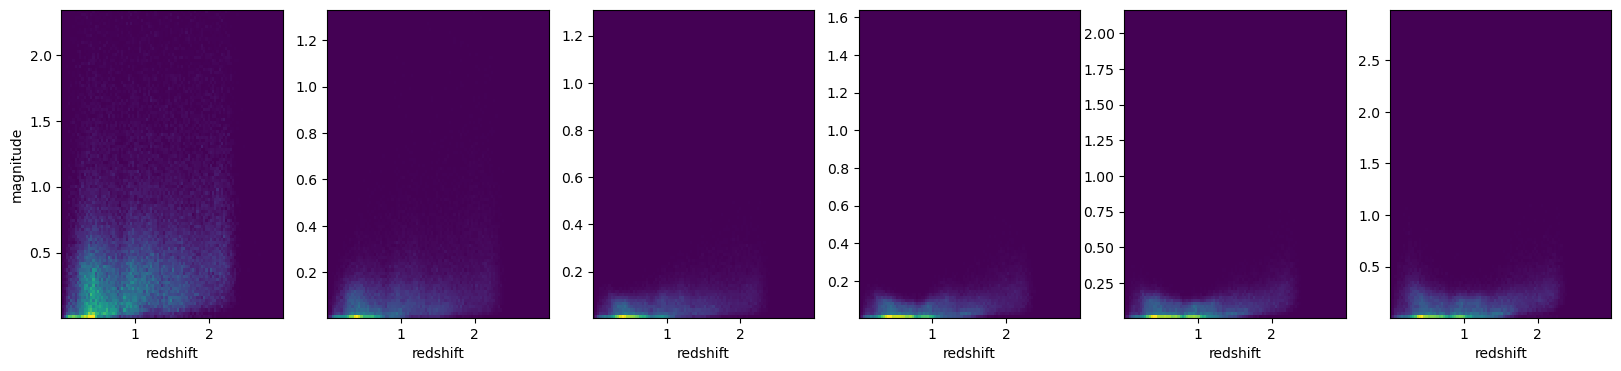

In [ ]:
fig, axes = plt.subplots(ncols = 6, figsize = (20, 4))
axes[0].hist2d(cleaned_redshift_err, cleaned_u_err, bins=100)
axes[0].set_xlabel('redshift')
axes[0].set_ylabel('magnitude')
axes[1].hist2d(cleaned_redshift_err, cleaned_g_err, bins=100)
axes[1].set_xlabel('redshift')
axes[2].hist2d(cleaned_redshift_err, cleaned_r_err, bins=100)
axes[2].set_xlabel('redshift')
axes[3].hist2d(cleaned_redshift_err, cleaned_i_err, bins=100)
axes[3].set_xlabel('redshift')
axes[4].hist2d(cleaned_redshift_err, cleaned_z_err, bins=100)
axes[4].set_xlabel('redshift')
axes[5].hist2d(cleaned_redshift_err, cleaned_y_err, bins=100)
axes[5].set_xlabel('redshift')

#confused ... :/

## Color Plots

### Training Set

Text(0.5, 0, 'redshift')

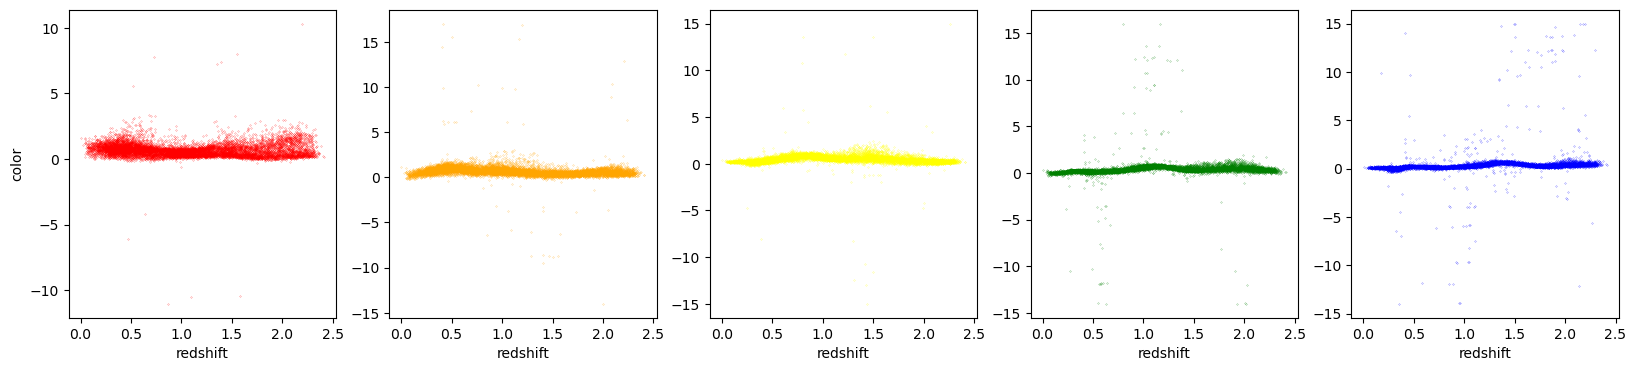

In [ ]:
# color plots

#undegraded training 

c_1_1 = u_1 - g_1
c_1_2 = g_1 - r_1
c_1_3 = r_1 - i_1
c_1_4 = i_1 - z_1
c_1_5 = z_1 - y_1 

fig, axes = plt.subplots(ncols = 5, figsize = (20, 4))
axes[0].scatter(redshift_1 ,c_1_1, c="red", marker=".", s=.1)
axes[0].set_xlabel('redshift')
axes[0].set_ylabel('color')
axes[1].scatter(redshift_1, c_1_2, c="orange", marker=".", s=.1)
axes[1].set_xlabel('redshift')
axes[2].scatter(redshift_1, c_1_3, c="yellow", marker=".",s=.1)
axes[2].set_xlabel('redshift')
axes[3].scatter(redshift_1, c_1_4, c="green", marker=".", s=.1)
axes[3].set_xlabel('redshift')
axes[4].scatter(redshift_1, c_1_5, c="blue", marker=".", s=.1)
axes[4].set_xlabel('redshift')


Text(0.5, 0, 'redshift')

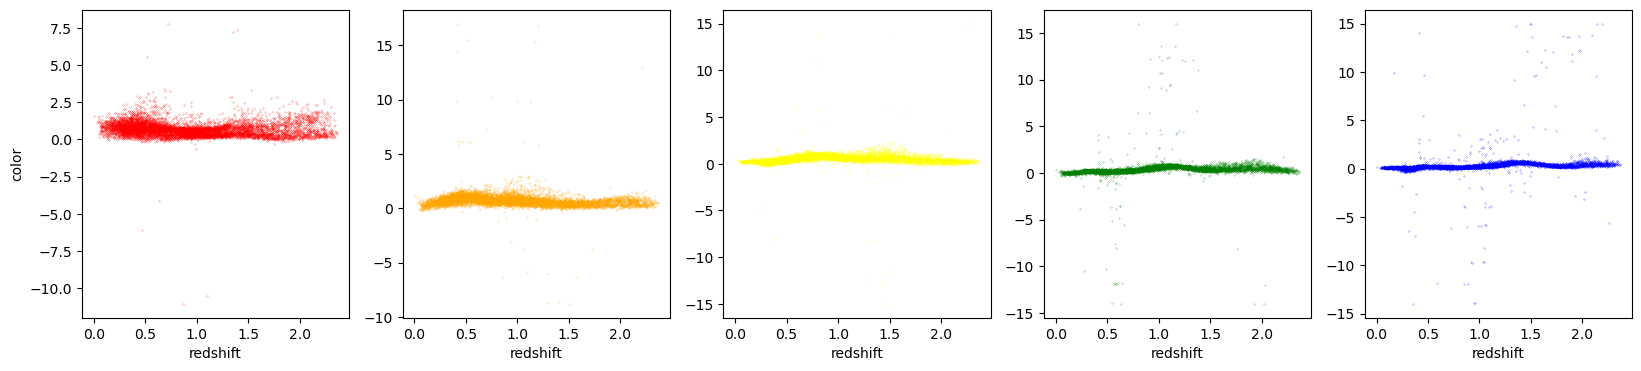

In [ ]:
#degraded training 

c_2_1 = u_2 - g_2
c_2_2 = g_2 - r_2
c_2_3 = r_2 - i_2
c_2_4 = i_2 - z_2
c_2_5 = z_2 - y_2 

fig, axes = plt.subplots(ncols = 5, figsize = (20, 4))
axes[0].scatter(redshift_2 ,c_2_1, c="red", marker=".", s=.1)
axes[0].set_xlabel('redshift')
axes[0].set_ylabel('color')
axes[1].scatter(redshift_2, c_2_2, c="orange", marker=".", s=.1)
axes[1].set_xlabel('redshift')
axes[2].scatter(redshift_2, c_2_3, c="yellow", marker=".", s=.1)
axes[2].set_xlabel('redshift')
axes[3].scatter(redshift_2, c_2_4, c="green", marker=".", s=.1)
axes[3].set_xlabel('redshift')
axes[4].scatter(redshift_2, c_2_5, c="blue", marker=".", s=.1)
axes[4].set_xlabel('redshift')

### Test Set

Text(0.5, 0, 'redshift')

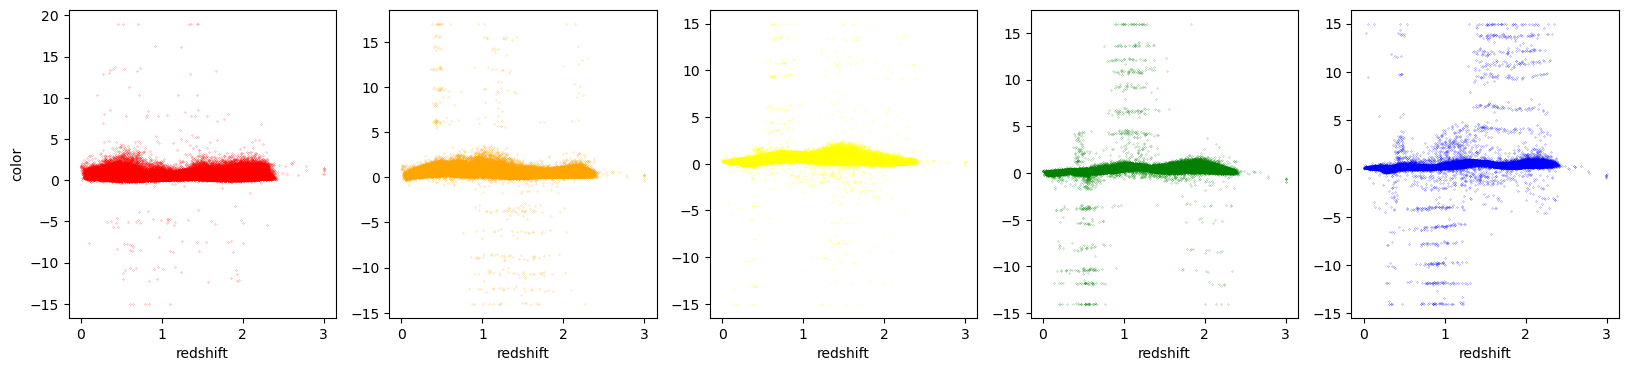

In [ ]:
#undegraded test 

c_3_1 = u_3 - g_3
c_3_2 = g_3 - r_3
c_3_3 = r_3 - i_3
c_3_4 = i_3 - z_3
c_3_5 = z_3 - y_3 

fig, axes = plt.subplots(ncols = 5, figsize = (20, 4))
axes[0].scatter(redshift_3 ,c_3_1, c="red", marker=".", s=.1)
axes[0].set_xlabel('redshift')
axes[0].set_ylabel('color')
axes[1].scatter(redshift_3, c_3_2, c="orange", marker=".", s=.1)
axes[1].set_xlabel('redshift')
axes[2].scatter(redshift_3, c_3_3, c="yellow", marker=".",s=.1)
axes[2].set_xlabel('redshift')
axes[3].scatter(redshift_3, c_3_4, c="green", marker=".", s=.1)
axes[3].set_xlabel('redshift')
axes[4].scatter(redshift_3, c_3_5, c="blue", marker=".",s=.1)
axes[4].set_xlabel('redshift')

Text(0.5, 0, 'redshift')

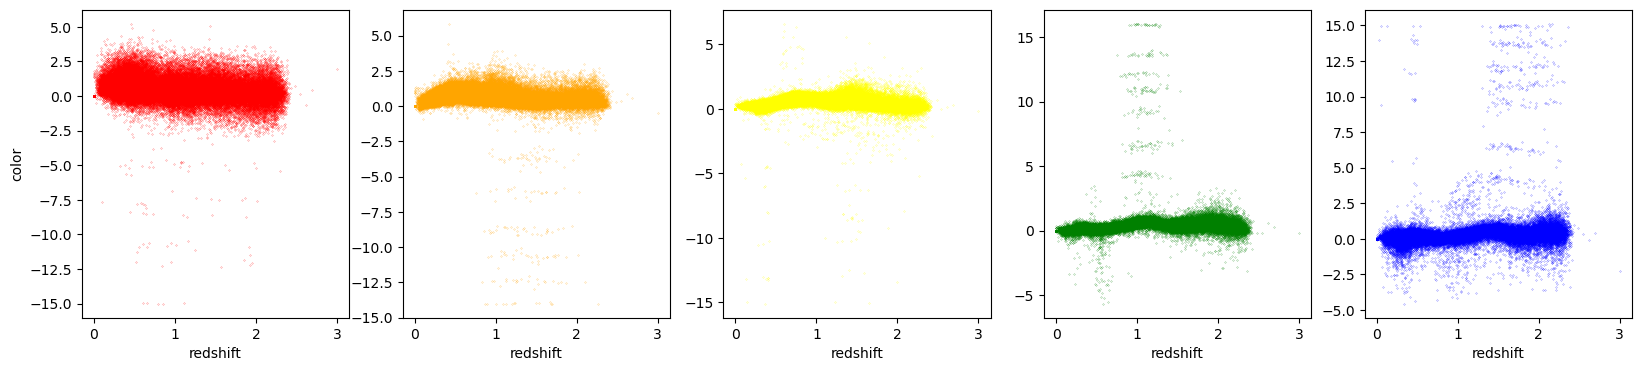

In [ ]:
#degraded test 

c_4_1 = u_4 - g_4
c_4_2 = g_4 - r_4
c_4_3 = r_4 - i_4
c_4_4 = i_4 - z_4
c_4_5 = z_4 - y_4 

fig, axes = plt.subplots(ncols = 5, figsize = (20, 4))
axes[0].scatter(redshift_4 ,c_4_1, c="red", marker=".", s=.1)
axes[0].set_xlabel('redshift')
axes[0].set_ylabel('color')
axes[1].scatter(redshift_4, c_4_2, c="orange", marker=".", s=.1)
axes[1].set_xlabel('redshift')
axes[2].scatter(redshift_4, c_4_3, c="yellow", marker=".", s=.1)
axes[2].set_xlabel('redshift')
axes[3].scatter(redshift_4, c_4_4, c="green", marker=".",s=.1)
axes[3].set_xlabel('redshift')
axes[4].scatter(redshift_4, c_4_5, c="blue", marker=".", s=.1)
axes[4].set_xlabel('redshift')

(-20.0, 20.0)

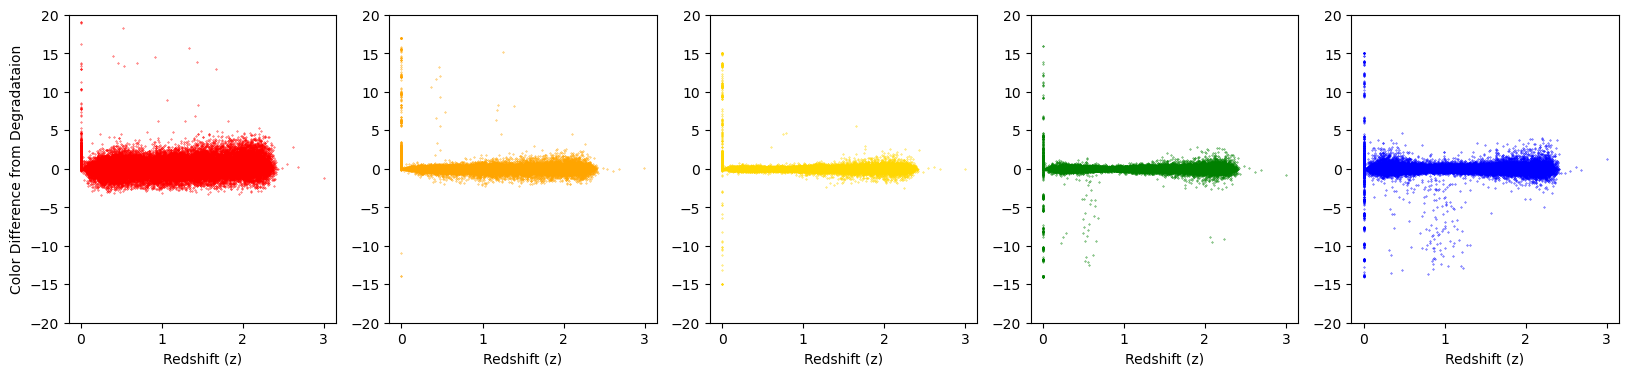

In [ ]:
c_diff_1 = c_3_1 - c_4_1
c_diff_2 = c_3_2 - c_4_2
c_diff_3 = c_3_3 - c_4_3
c_diff_4 = c_3_4 - c_4_4
c_diff_5 = c_3_5 - c_4_5



fig, axes = plt.subplots(ncols = 5, figsize = (20, 4))
axes[0].scatter(redshift_4 ,c_diff_1, c="red", marker="o", s=.1)
axes[0].set_xlabel('Redshift (z)')
axes[0].set_ylabel('Color Difference from Degradataion')
axes[0].set_ylim(ymin = -20, ymax = 20)
axes[1].scatter(redshift_4, c_diff_2, c="orange", marker="o", s=.1)
axes[1].set_xlabel('Redshift (z)')
axes[1].set_ylim(ymin = -20, ymax = 20)
axes[2].scatter(redshift_4, c_diff_3, c="gold", marker="o", s=.1)
axes[2].set_xlabel('Redshift (z)')
axes[2].set_ylim(ymin = -20, ymax = 20)
axes[3].scatter(redshift_4, c_diff_4, c="green", marker="o", s=.1)
axes[3].set_xlabel('Redshift (z)')
axes[3].set_ylim(ymin = -20, ymax = 20)
axes[4].scatter(redshift_4, c_diff_5, c="blue", marker="o", s=.1)
axes[4].set_xlabel('Redshift (z)')
axes[4].set_ylim(ymin = -20, ymax = 20)

# Perform Estimations with FlexzBoost

This cell is also slow, ~30s 

In [11]:
# inform the estimator

inform_fzboost = Inform_FZBoost.make_stage(
    name='inform_FZBoost', 
    model='fzboost.pkl', 
    hdf5_groupname='',
)

In [13]:
inform_fzboost.inform(deg_train_data)

stacking some data...
read in training data
fit the model...


/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/flexzboost.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.loc[detmask, errname] = 1.0
/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/flexzboost.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_data.loc[detmask, errname] = 1.0
/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/flexzboost.py:134: SettingWithCopy

[12:31:20] WARNING: /private/var/folders/jl/5jxwvx_x5q364l56c4qph1g00000gn/T/pip-install-eeaedq5e/xgboost_e2bb7fd5d4194af8881e01ff690195d0/build/temp.macosx-11.0-arm64-cpython-310/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[12:31:20] WARNING: /private/var/folders/jl/5jxwvx_x5q364l56c4qph1g00000gn/T/pip-install-eeaedq5e/xgboost_e2bb7fd5d4194af8881e01ff690195d0/build/temp.macosx-11.0-arm64-cpython-310/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[12:31:20] WARNING: /private/var/folders/jl/5jxwvx_x5q364l56c4qph1g00000gn/T/pip-install-eeaedq5e/xgboost_e2bb7fd5d4194af8881e01ff690195d0/build/temp.macosx-11.0-arm64-cpython-310/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[12:31:20] WARNING: /private/var/folders/jl/5jxwvx_x5q364l56c4qph1g00000gn/T/pip-install-eeaedq5e/xgboost_e2bb7fd5d4194af8881e01ff690195d0/build/temp.macosx-11.0-arm64-cpython-310/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[12:

Slow cell, ~30s

In [14]:
# perform the estimation

estimate_fzboost = FZBoost.make_stage(
    name='test_FZBoost', 
    nondetect_val=np.nan,
    model=inform_fzboost.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='fzboost_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

In [15]:

fzboost_estimated = estimate_fzboost.estimate(deg_test_data)

Process 0 running estimator on chunk 0 - 100000
Process 0 estimating PZ PDF for rows 0 - 100,000
Inserting handle into data store.  output_test_FZBoost: inprogress_output_test_FZBoost.hdf5, test_FZBoost


In [121]:
## what you can change in this estimator and how 

estimate_fzboost.config_options 

{'output_mode': <ceci.config.StageParameter at 0x1619931f0>,
 'chunk_size': 10000,
 'hdf5_groupname': str,
 'nzbins': StageConfig{hdf5_groupname:photometry,zmin:0.0,zmax:3.0,nzbins:301,dz:0.01,nondetect_val:99.0,bands:['mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst'],err_bands:['mag_err_u_lsst', 'mag_err_g_lsst', 'mag_err_r_lsst', 'mag_err_i_lsst', 'mag_err_z_lsst', 'mag_err_y_lsst'],mag_limits:{'mag_u_lsst': 27.79, 'mag_g_lsst': 29.04, 'mag_r_lsst': 29.06, 'mag_i_lsst': 28.62, 'mag_z_lsst': 27.98, 'mag_y_lsst': 27.05},ref_band:mag_i_lsst,redshift_col:redshift,},
 'nondetect_val': StageConfig{hdf5_groupname:photometry,zmin:0.0,zmax:3.0,nzbins:301,dz:0.01,nondetect_val:99.0,bands:['mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst', 'mag_z_lsst', 'mag_y_lsst'],err_bands:['mag_err_u_lsst', 'mag_err_g_lsst', 'mag_err_r_lsst', 'mag_err_i_lsst', 'mag_err_z_lsst', 'mag_err_y_lsst'],mag_limits:{'mag_u_lsst': 27.79, 'mag_g_lsst': 29.04, 'mag_r_lsst': 29.06

## Deal w outputs 

In [14]:


import h5py

f = h5py.File('output_test_FZBoost.hdf5', 'r')
list(f.keys())

ancil = f['ancil']
data = f['data']
meta = f['meta']

print(f)



<HDF5 file "output_test_FZBoost.hdf5" (mode r)>


In [271]:
# h = qp.read('output_test_FZBoost.hdf5')
# print(type(h))

In [15]:

zmode = ancil['zmode']
yvals = data['yvals']
pdf_name = meta['pdf_name'] #not useful 
pdf_version = meta['pdf_version'] #not useful 
xvals = meta['xvals']

zmode.shape # (100,000 , 1)
yvals.shape # (100,000, 301)
pdf_name.shape 
pdf_version.shape
xvals.shape # (1, 301)


# eval_ens = yvals 
# help(qp.Ensemble)

## each row in yvals corresponds to a galaxy 
## each galaxy has 301 datapoints of information about it. Every galaxy has the same x values, that's why xvals is a 1D array
## zmode ??


(1, 100)

## Let's run the estimator on the training data, just for kicks 

Should do incredibly well!! 

In [270]:
estimate_fzboost_on_train = FZBoost.make_stage(
    name='FZBoost_on_train', 
    nondetect_val=np.nan,
    model=inform_fzboost.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='train_data', output='fzboost_estim'),
    nzbins = 100,
    zmax = 2.5
)

fzboost_estimated_on_train = estimate_fzboost_on_train.estimate(deg_train_data)

Process 0 running estimator on chunk 0 - 8315
Process 0 estimating PZ PDF for rows 0 - 8,315


/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/flexzboost.py:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[detmask, errname] = 1.0
/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/flexzboost.py:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[detmask, errname] = 1.0
/Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/estimation/algos/flexzboost.py:212: SettingWithCopyWarning: 
A value 

Inserting handle into data store.  output_FZBoost_on_train: inprogress_output_FZBoost_on_train.hdf5, FZBoost_on_train


In [16]:

import h5py

f = h5py.File('output_FZBoost_on_train.hdf5', 'r')
list(f.keys())

ancil = f['ancil']
data = f['data']
meta = f['meta']

print(f)


<HDF5 file "output_FZBoost_on_train.hdf5" (mode r)>


### I know this is out of order, but evaluation of this estimate:

In [46]:
import h5py 
import qp

h= DS.read_file('pdfs_data', QPHandle, 'output_FZBoost_on_train.hdf5')
est_on_train_yvals = h().objdata()['yvals']
est_on_train_xvals = h().metadata()['xvals'][0]
est_on_train_ens = qp.Ensemble(qp.interp, data=dict(xvals=est_on_train_xvals, yvals=est_on_train_yvals))

In [47]:
j = DS.read_file('pdfs_data', QPHandle, 'output_truth_post_deg_train.hdf5') 
train_yvals = j().objdata()['yvals']
train_xvals = j().metadata()['xvals'][0]
train_ens = qp.Ensemble(qp.interp, data=dict(xvals=train_xvals, yvals=train_yvals))

print(train_yvals)

[[1.45535576e-03 5.48770504e-05 2.86185309e-05 ... 1.09629773e-21
  3.39564260e-21 8.96807827e-24]
 [1.64030225e-13 1.29136149e-17 5.43045047e-17 ... 1.43979326e-17
  6.01354821e-18 2.83650621e-18]
 [8.73818041e-08 5.55701822e-11 1.17259018e-10 ... 3.25102599e-19
  2.80202487e-19 1.22968694e-21]
 ...
 [6.09768710e-34 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.37394885e-10 3.16890167e-22 1.58491266e-22 ... 0.00000000e+00
  0.00000000e+00 1.16834027e-26]
 [1.54409718e-06 1.41378830e-12 7.38970742e-10 ... 4.89427569e-18
  3.24859242e-20 0.00000000e+00]]


In [48]:
lims = np.array([0, 2.5])
grid = np.linspace(0, 2.5, 100)

klds_1 = qp.metrics.calculate_kld(train_ens, est_on_train_ens, limits=lims, dx = grid[1] - grid[0])
print("KLD value is:", klds_1)

KLD value is: [2.251329   1.90659552 0.39967856 ... 0.32266861 0.6456817  0.44079627]


(-5.0, 80.0)

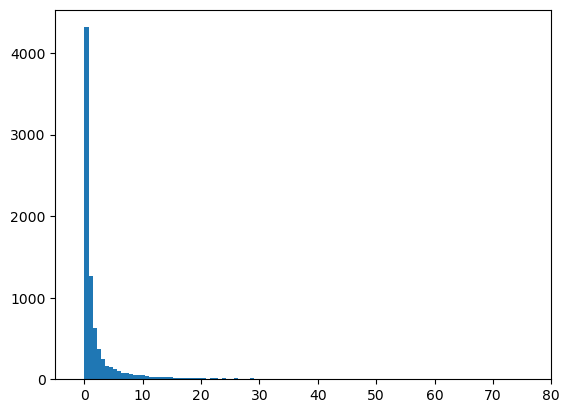

In [50]:
plt.hist(klds_1, bins = 100)
plt.xlim(-5, 80)
# plt.semilogy()

## Plot Some Data

### Nice!

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


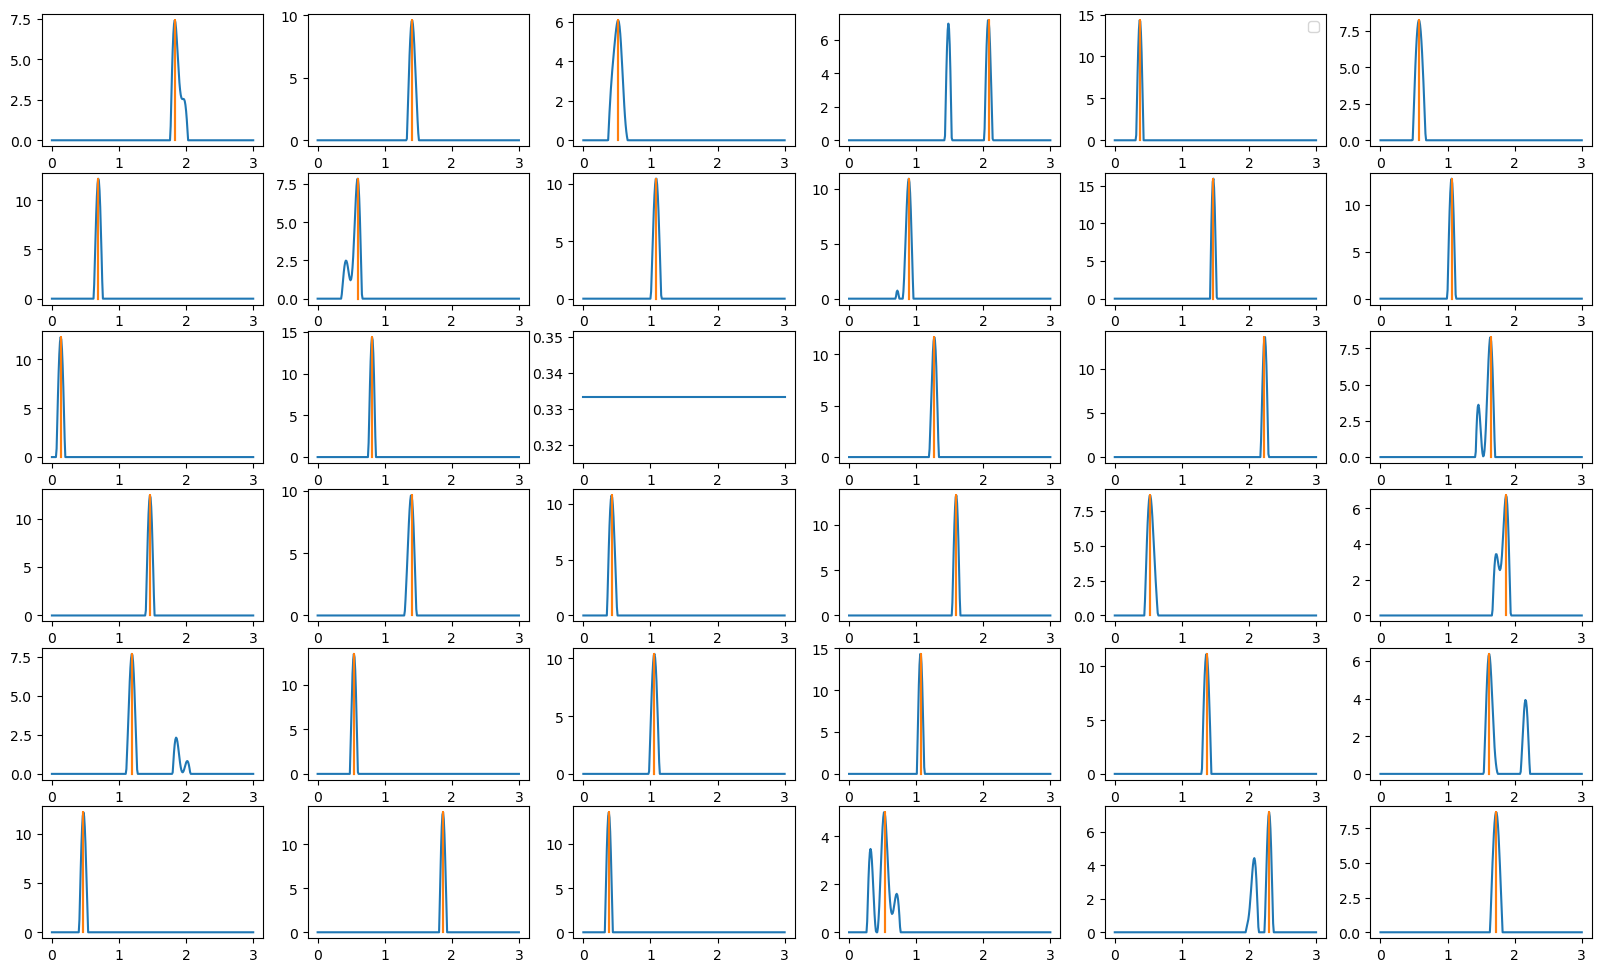

In [38]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(nrows = 6, ncols = 6, figsize = (20, 12)) 

ct = 0
for i in range(0, 6):
    for j in range(0, 6):
        axes[i][j].plot(xvals[0], yvals[ct])
        axes[i][j].plot(zmode[ct]*np.ones(301), yvals[ct])
        ct += 1
axes[0][4].legend()

## Fit Gaussians

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Redshift (z)')

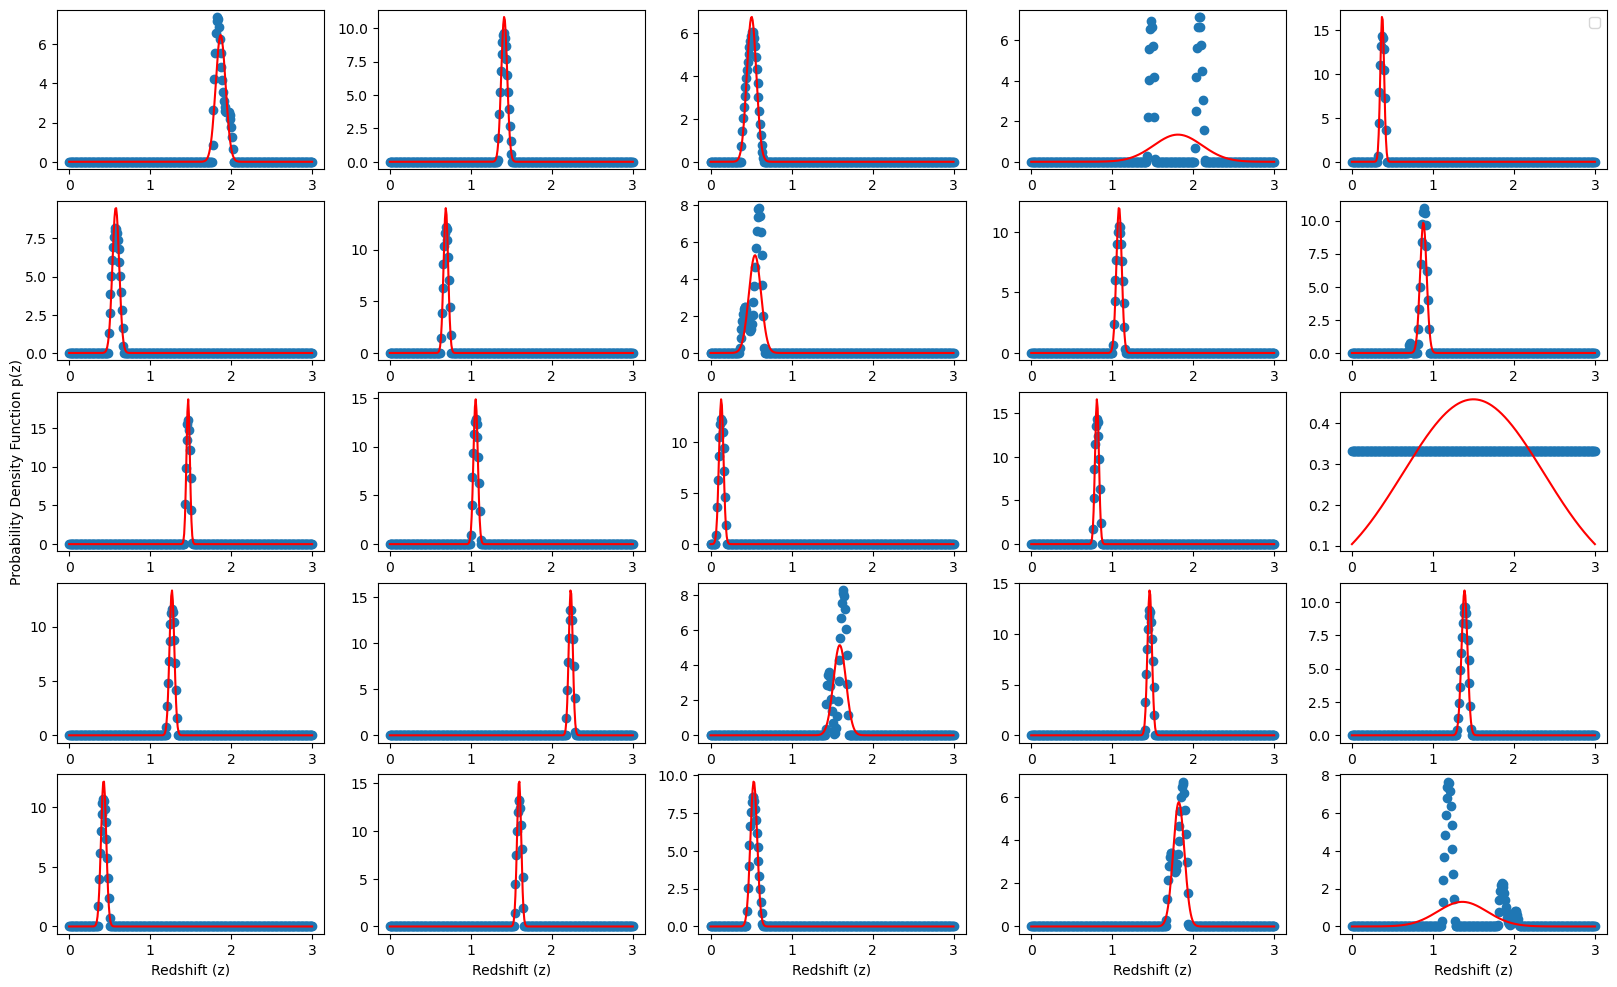

In [39]:
import numpy as np
from scipy.stats import norm

mean_00 = np.sum(xvals[0] * yvals[0]) / np.sum(yvals[0])
var_00 = np.sum((mean_00 - xvals[0])**2 * yvals[0]) / np.sum(yvals[0])

mean_01 = np.sum(xvals[0] * yvals[1]) / np.sum(yvals[1])
var_01 = np.sum((mean_01 - xvals[0])**2 * yvals[1]) / np.sum(yvals[1])

mean_02 = np.sum(xvals[0] * yvals[2]) / np.sum(yvals[2])
var_02 = np.sum((mean_02 - xvals[0])**2 * yvals[2]) / np.sum(yvals[2])

mean_03 = np.sum(xvals[0] * yvals[3]) / np.sum(yvals[3])
var_03 = np.sum((mean_03 - xvals[0])**2 * yvals[3]) / np.sum(yvals[3])

mean_04 = np.sum(xvals[0] * yvals[4]) / np.sum(yvals[4])
var_04 = np.sum((mean_04 - xvals[0])**2 * yvals[4]) / np.sum(yvals[4])

mean_10 = np.sum(xvals[0] * yvals[5]) / np.sum(yvals[5])
var_10 = np.sum((mean_10 - xvals[0])**2 * yvals[5]) / np.sum(yvals[5])

mean_11 = np.sum(xvals[0] * yvals[6]) / np.sum(yvals[6])
var_11 = np.sum((mean_11 - xvals[0])**2 * yvals[6]) / np.sum(yvals[6])

mean_12 = np.sum(xvals[0] * yvals[7]) / np.sum(yvals[7])
var_12 = np.sum((mean_12 - xvals[0])**2 * yvals[7]) / np.sum(yvals[7])

mean_13 = np.sum(xvals[0] * yvals[8]) / np.sum(yvals[8])
var_13 = np.sum((mean_13 - xvals[0])**2 * yvals[8]) / np.sum(yvals[8])

mean_14 = np.sum(xvals[0] * yvals[9]) / np.sum(yvals[9])
var_14 = np.sum((mean_14 - xvals[0])**2 * yvals[9]) / np.sum(yvals[9])

mean_20 = np.sum(xvals[0] * yvals[10]) / np.sum(yvals[10])
var_20 = np.sum((mean_20 - xvals[0])**2 * yvals[10]) / np.sum(yvals[10])

mean_21 = np.sum(xvals[0] * yvals[11]) / np.sum(yvals[11])
var_21 = np.sum((mean_21 - xvals[0])**2 * yvals[11]) / np.sum(yvals[11])

mean_22 = np.sum(xvals[0] * yvals[12]) / np.sum(yvals[12])
var_22 = np.sum((mean_22 - xvals[0])**2 * yvals[12]) / np.sum(yvals[12])

mean_23 = np.sum(xvals[0] * yvals[13]) / np.sum(yvals[13])
var_23 = np.sum((mean_23 - xvals[0])**2 * yvals[13]) / np.sum(yvals[13])

mean_24 = np.sum(xvals[0] * yvals[14]) / np.sum(yvals[14])
var_24 = np.sum((mean_24 - xvals[0])**2 * yvals[14]) / np.sum(yvals[14])

mean_30 = np.sum(xvals[0] * yvals[15]) / np.sum(yvals[15])
var_30 = np.sum((mean_30 - xvals[0])**2 * yvals[15]) / np.sum(yvals[15])

mean_31 = np.sum(xvals[0] * yvals[16]) / np.sum(yvals[16])
var_31 = np.sum((mean_31 - xvals[0])**2 * yvals[16]) / np.sum(yvals[16])

mean_32 = np.sum(xvals[0] * yvals[17]) / np.sum(yvals[17])
var_32 = np.sum((mean_32 - xvals[0])**2 * yvals[17]) / np.sum(yvals[17])

mean_33 = np.sum(xvals[0] * yvals[18]) / np.sum(yvals[18])
var_33 = np.sum((mean_33 - xvals[0])**2 * yvals[18]) / np.sum(yvals[18])

mean_34 = np.sum(xvals[0] * yvals[19]) / np.sum(yvals[19])
var_34 = np.sum((mean_34 - xvals[0])**2 * yvals[19]) / np.sum(yvals[19])

mean_40 = np.sum(xvals[0] * yvals[20]) / np.sum(yvals[20])
var_40 = np.sum((mean_40 - xvals[0])**2 * yvals[20]) / np.sum(yvals[20])

mean_41 = np.sum(xvals[0] * yvals[21]) / np.sum(yvals[21])
var_41 = np.sum((mean_41 - xvals[0])**2 * yvals[21]) / np.sum(yvals[21])

mean_42 = np.sum(xvals[0] * yvals[22]) / np.sum(yvals[22])
var_42 = np.sum((mean_42 - xvals[0])**2 * yvals[22]) / np.sum(yvals[22])

mean_43 = np.sum(xvals[0] * yvals[23]) / np.sum(yvals[23])
var_43 = np.sum((mean_43 - xvals[0])**2 * yvals[23]) / np.sum(yvals[23])

mean_44 = np.sum(xvals[0] * yvals[24]) / np.sum(yvals[24])
var_44 = np.sum((mean_44 - xvals[0])**2 * yvals[24]) / np.sum(yvals[24])


fig, axes = plt.subplots(nrows = 5, ncols = 5, figsize = (20, 12))
axes[0][0].scatter(xvals[0], yvals[0])
axes[0][0].plot(xvals[0], norm.pdf(xvals[0], mean_00, var_00**.5), color = "red")
axes[0][1].scatter(xvals[0], yvals[1])
axes[0][1].plot(xvals[0], norm.pdf(xvals[0], mean_01, var_01**.5), color = "red")
axes[0][2].scatter(xvals[0], yvals[2])
axes[0][2].plot(xvals[0], norm.pdf(xvals[0], mean_02, var_02**.5), color = "red")
axes[0][3].scatter(xvals[0], yvals[3])
axes[0][3].plot(xvals[0], norm.pdf(xvals[0], mean_03, var_03**.5), color = "red")
axes[0][4].scatter(xvals[0], yvals[4])
axes[0][4].plot(xvals[0], norm.pdf(xvals[0], mean_04, var_04**.5), color = "red")
axes[0][4].legend()

axes[1][0].scatter(xvals[0], yvals[5])
axes[1][0].plot(xvals[0], norm.pdf(xvals[0], mean_10, var_10**.5), color = "red")
axes[1][1].scatter(xvals[0], yvals[6])
axes[1][1].plot(xvals[0], norm.pdf(xvals[0], mean_11, var_11**.5), color = "red")
axes[1][2].scatter(xvals[0], yvals[7])
axes[1][2].plot(xvals[0], norm.pdf(xvals[0], mean_12, var_12**.5), color = "red")
axes[1][3].scatter(xvals[0], yvals[8])
axes[1][3].plot(xvals[0], norm.pdf(xvals[0], mean_13, var_13**.5), color = "red")
axes[1][4].scatter(xvals[0], yvals[9])
axes[1][4].plot(xvals[0], norm.pdf(xvals[0], mean_14, var_14**.5), color = "red")

axes[2][0].scatter(xvals[0], yvals[10])
axes[2][0].plot(xvals[0], norm.pdf(xvals[0], mean_20, var_20**.5), color = "red")
axes[2][0].set_ylabel('Probability Density Function p(z)')
axes[2][1].scatter(xvals[0], yvals[11])
axes[2][1].plot(xvals[0], norm.pdf(xvals[0], mean_21, var_21**.5), color = "red")
axes[2][2].scatter(xvals[0], yvals[12])
axes[2][2].plot(xvals[0], norm.pdf(xvals[0], mean_22, var_22**.5), color = "red")
axes[2][3].scatter(xvals[0], yvals[13])
axes[2][3].plot(xvals[0], norm.pdf(xvals[0], mean_23, var_23**.5), color = "red")
axes[2][4].scatter(xvals[0], yvals[14])
axes[2][4].plot(xvals[0], norm.pdf(xvals[0], mean_24, var_24**.5), color = "red")

axes[3][0].scatter(xvals[0], yvals[15])
axes[3][0].plot(xvals[0], norm.pdf(xvals[0], mean_30, var_30**.5), color = "red")
axes[3][1].scatter(xvals[0], yvals[16])
axes[3][1].plot(xvals[0], norm.pdf(xvals[0], mean_31, var_31**.5), color = "red")
axes[3][2].scatter(xvals[0], yvals[17])
axes[3][2].plot(xvals[0], norm.pdf(xvals[0], mean_32, var_32**.5), color = "red")
axes[3][3].scatter(xvals[0], yvals[18])
axes[3][3].plot(xvals[0], norm.pdf(xvals[0], mean_33, var_33**.5), color = "red")
axes[3][4].scatter(xvals[0], yvals[19])
axes[3][4].plot(xvals[0], norm.pdf(xvals[0], mean_34, var_34**.5), color = "red")

axes[4][0].scatter(xvals[0], yvals[20])
axes[4][0].plot(xvals[0], norm.pdf(xvals[0], mean_40, var_40**.5), color = "red")
axes[4][0].set_xlabel('Redshift (z)')
axes[4][1].scatter(xvals[0], yvals[21])
axes[4][1].plot(xvals[0], norm.pdf(xvals[0], mean_41, var_41**.5), color = "red")
axes[4][1].set_xlabel('Redshift (z)')
axes[4][2].scatter(xvals[0], yvals[22])
axes[4][2].plot(xvals[0], norm.pdf(xvals[0], mean_42, var_42**.5), color = "red")
axes[4][2].set_xlabel('Redshift (z)')
axes[4][3].scatter(xvals[0], yvals[23])
axes[4][3].plot(xvals[0], norm.pdf(xvals[0], mean_43, var_43**.5), color = "red")
axes[4][3].set_xlabel('Redshift (z)')
axes[4][4].scatter(xvals[0], yvals[24])
axes[4][4].plot(xvals[0], norm.pdf(xvals[0], mean_44, var_44**.5), color = "red")
axes[4][4].set_xlabel('Redshift (z)')


## Accuracy Plots

Text(0.5, 1.0, 'Gaussianity of Estimator Output Data')

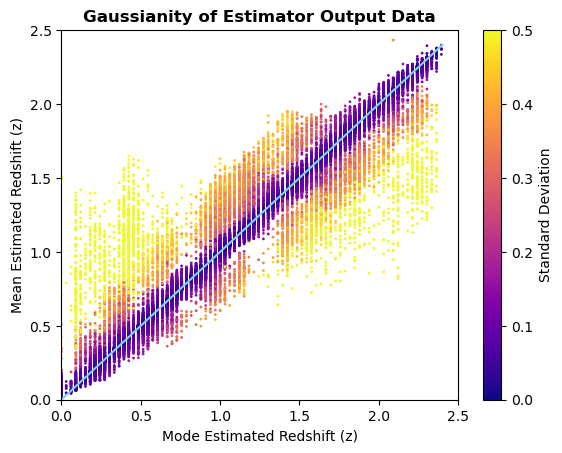

In [256]:
# plot of true redshift vs mean estimated redshift 
import matplotlib.pyplot as plt 
from matplotlib import cm 

mean_ls = []
stdev_ls = []
for i in range(0, 100000): 
    mean = np.sum(xvals[0] * yvals[i]) / np.sum(yvals[i])
    var = np.sum((mean - xvals[0])**2 * yvals[i]) / np.sum(yvals[i])
    stdev = np.sqrt(var)
    mean_ls.append(mean)
    stdev_ls.append(stdev)

mean_z = np.asarray(mean_ls) 
stdev_z = np.asarray(stdev_ls)
z_true = redshift_3 

arr = np.arange(0, 2.5, 0.1)


plt.scatter(zmode, mean_z, s=1, c = stdev_z, cmap = cm.plasma, vmin = 0, vmax = 0.5)
plt.plot(arr, arr, color = "skyblue")
plt.xlabel('Mode Estimated Redshift (z)')
plt.ylabel('Mean Estimated Redshift (z)')
plt.xlim(0, 2.5)
plt.ylim(0, 2.5)
plt.colorbar(label = 'Standard Deviation')
plt.title("Gaussianity of Estimator Output Data", fontsize = 'large', fontweight = 'bold')


## plot of mean redshift vs. mode redshift, with the orange line being equality --> essentially intended to quantify how gaussian the data looks: (cause gaussian --> mean = mode) 
## pretty good, but we see more mean>mode errors for low z and more mode>mean errors for high z; possibly means we are having more multiple-peak errors 
## we are not very accurate for high redshifts, as to be expected, since we cut them from the training set 

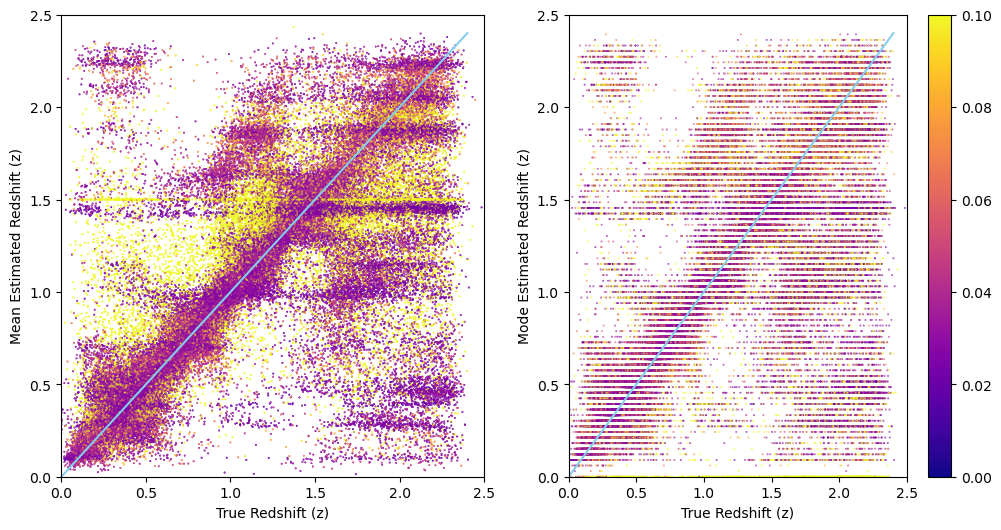

In [255]:
fig, axes = plt.subplots(ncols = 2, figsize = (12, 6))
axes[0].scatter(redshift_3, mean_z, s=0.1, c = stdev_z, cmap = cm.plasma, vmin = 0, vmax = 0.1)
axes[0].plot(arr, arr, color = "skyblue")
axes[0].set_xlabel('True Redshift (z)')
axes[0].set_ylabel('Mean Estimated Redshift (z)')
axes[0].set_xlim(0, 2.5)
axes[0].set_ylim(0, 2.5)
axes[1].scatter(redshift_3, zmode, s=0.1, c = stdev_z, cmap = cm.plasma, vmin = 0, vmax = 0.1)
axes[1].plot(arr, arr, color = "skyblue")
axes[1].set_xlabel('True Redshift (z)')
axes[1].set_ylabel('Mode Estimated Redshift (z)')
axes[1].set_xlim(0, 2.5)
axes[1].set_ylim(0, 2.5)

data = axes[0].scatter(redshift_3, mean_z, s=0.1, c = stdev_z, cmap = cm.plasma, vmin = 0, vmax = 0.1)
fig.colorbar(data, ax=axes[1])

## in second two plots, colormap corresponds to the size of the variance for each gaussian 

In [160]:
mode_z = []
for i in range(len(zmode)):
    mode_z.append(zmode[i][0])
mode_z = np.asarray(mode_z)

## Catastrophic Outlier Rates

### Outlier Rejection 


In [19]:
import numpy as np
import scipy 
from scipy import stats

def outlierRejection(ls, lim):
    mean = np.mean(ls)
    stdev = stats.tstd(ls)
    ct = 0
    for i in ls:
        if np.abs(mean - i) > 3*stdev:
            ls.remove(i) 
            ct += 1
    if ct <= lim:
        return ls
    else:
        return outlierRejection(ls, lim)


In [186]:
z_diff_mean = mean_z - z_true
lsme = z_diff_mean.tolist()
a = outlierRejection(lsme, 0)

In [187]:
z_diff_mode = mode_z - z_true
lsmo = z_diff_mode.tolist()
b = outlierRejection(lsmo, 0)

In [188]:
not_outliers_mean = np.asarray(a)
not_outliers_mode = np.asarray(b)

In [189]:
mean_out_rate = (100000 - len(a)) / 1000
mode_out_rate = (100000 - len(b)) / 1000

print(mean_out_rate)

22.326


final variance is: 0.2020809315389737


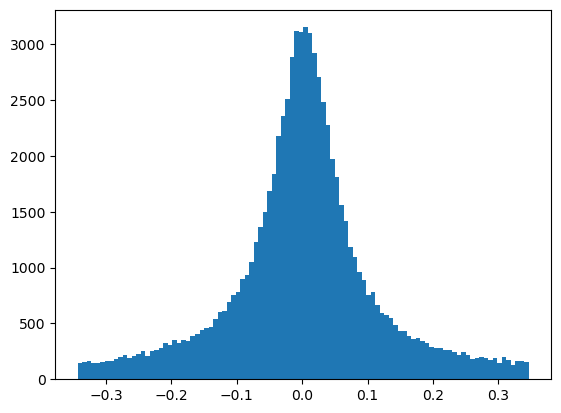

In [193]:
mean_hist = plt.hist(not_outliers_mean, bins = 100)

mean_hist_stdev = stats.tstd(mean_hist[1])
print('final variance is:', mean_hist_var)

(array([ 119.,  105.,  150.,  138.,  177.,  167.,  175.,  176.,  203.,
         188.,  191.,  236.,  216.,  219.,  249.,  242.,  249.,  274.,
         293.,  319.,  298.,  325.,  352.,  341.,  385.,  413.,  416.,
         461.,  488.,  532.,  552.,  586.,  638.,  700.,  779.,  829.,
         903.,  965., 1108., 1218., 1323., 1494., 1617., 1766., 2018.,
        2207., 2318., 2508., 2697., 2775., 2797., 2846., 2753., 2489.,
        2337., 2232., 2086., 1917., 1647., 1513., 1350., 1249., 1140.,
         979.,  891.,  843.,  741.,  681.,  575.,  635.,  568.,  520.,
         458.,  402.,  413.,  368.,  347.,  310.,  310.,  320.,  309.,
         265.,  230.,  191.,  221.,  215.,  206.,  203.,  191.,  154.,
         168.,  163.,  145.,  137.,  132.,  134.,  111.,  112.,  135.,
         113.]),
 array([-0.30604446, -0.29994047, -0.29383648, -0.28773249, -0.28162851,
        -0.27552452, -0.26942053, -0.26331655, -0.25721256, -0.25110857,
        -0.24500458, -0.2389006 , -0.23279661, -0.226692

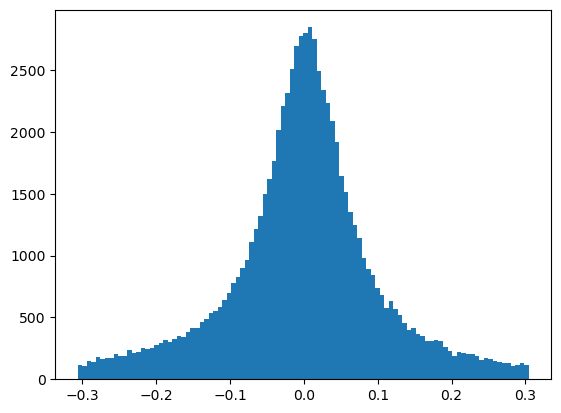

In [165]:
plt.hist(not_outliers_mode, bins = 100)

In [166]:
indsme = []
for i in range(len(not_outliers_mean)):
    indsme.append(np.where(z_diff_mean == not_outliers_mean[i])[0][0])
print(indsme)

[0, 1, 2, 3, 4, 6, 7, 9, 11, 13, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 69, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 84, 85, 87, 88, 90, 92, 93, 94, 95, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 111, 115, 116, 117, 118, 120, 121, 122, 124, 127, 128, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 152, 153, 154, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 170, 171, 172, 173, 174, 177, 179, 181, 184, 187, 188, 189, 191, 193, 194, 196, 197, 198, 201, 202, 203, 204, 205, 208, 209, 212, 213, 215, 216, 217, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 233, 235, 236, 237, 239, 240, 241, 242, 243, 244, 245, 246, 248, 249, 250, 252, 253, 255, 256, 257, 258, 259, 260, 262, 263, 264, 265, 266, 268, 269, 270, 272, 273, 274, 275, 277, 278, 279, 280, 281, 282, 283, 286, 287, 288, 290, 291, 29

In [167]:
mean_good = []
redshift_mean_good = []
for i in indsme:
    mean_good.append(mean_z[i])
    redshift_mean_good.append(z_true[i])
mean_good = np.asarray(mean_good)
redshift_mean_good= np.asarray(redshift_mean_good)

In [168]:
indsmo = []
for i in range(len(not_outliers_mode)):
    indsmo.append(np.where(z_diff_mode == not_outliers_mode[i])[0][0])
print(indsmo)

[0, 1, 2, 4, 6, 7, 9, 11, 13, 16, 17, 19, 20, 21, 22, 23, 25, 26, 29, 31, 32, 33, 34, 35, 36, 38, 39, 42, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 57, 58, 60, 63, 65, 66, 67, 71, 72, 73, 74, 75, 78, 79, 80, 81, 84, 85, 86, 87, 88, 90, 92, 93, 94, 95, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 115, 116, 117, 118, 120, 121, 122, 123, 124, 127, 128, 129, 131, 132, 133, 135, 136, 137, 139, 140, 141, 142, 143, 145, 146, 147, 148, 149, 150, 152, 153, 154, 156, 157, 159, 160, 162, 163, 164, 165, 166, 167, 170, 171, 172, 173, 174, 177, 179, 181, 184, 187, 188, 189, 191, 193, 194, 196, 197, 198, 201, 202, 203, 204, 205, 209, 212, 213, 215, 216, 217, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 233, 235, 237, 239, 240, 241, 242, 243, 244, 245, 246, 248, 249, 250, 252, 253, 255, 256, 257, 258, 259, 260, 262, 263, 264, 265, 266, 268, 269, 270, 272, 273, 274, 275, 277, 279, 281, 282, 283, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 30

In [169]:
mode_good = []
redshift_mode_good = []
for i in indsmo:
    mode_good.append(mode_z[i])
    redshift_mode_good.append(z_true[i])
mode_good = np.asarray(mode_good)
redshift_mode_good = np.asarray(redshift_mode_good)

### IQR 

In [ ]:
import numpy as np
import scipy.stats

mean_iqr = scipy.stats.iqr(mean_z)
mean_sigma_iqr = mean_iqr / 1.349
mode_iqr = scipy.stats.iqr(mode_z)
mode_sigma_iqr = mode_iqr / 1.349


In [ ]:
mme = np.mean(z_diff_mean)
gme = mean_z.tolist()
gme_z = z_true.tolist()

ind = 0
for i in z_diff_mean:
    ind += 1
    if np.abs(mme - i) > 3*mean_sigma_iqr:
        gme.pop(ind-1)
        gme_z.pop(ind-1)


99754


### Plots

outlier rate for mean is 22.326 %
final standard deviation is 0.2020809315389737
outlier rate for mode is 22.326 %


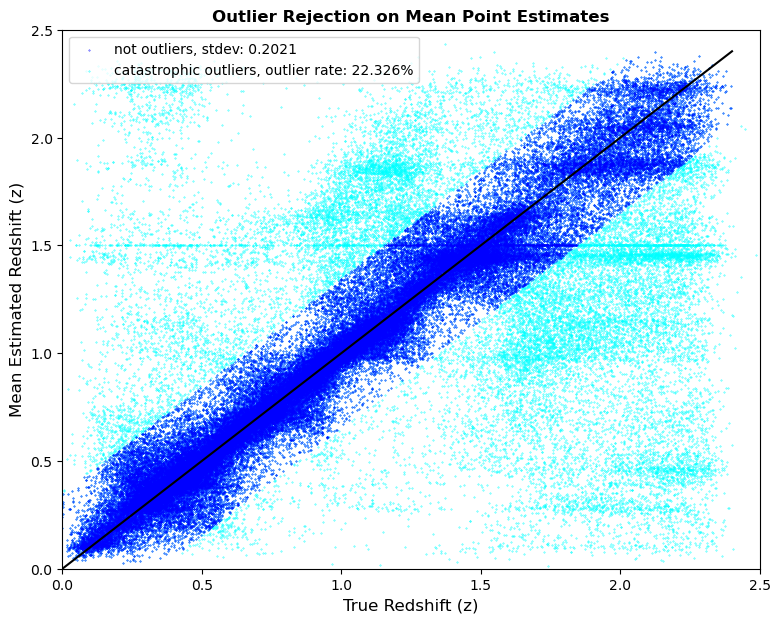

In [262]:
## outlier rejection: 

fig, ax = plt.subplots(figsize = (9, 7))
outliers = ax.scatter(z_true, mean_z, s=0.1, color = 'cyan')
pts = ax.scatter(redshift_mean_good, mean_good, s=0.1, color = 'blue')
ax.plot(arr, arr, color = "black")
ax.set_xlabel('True Redshift (z)', fontsize = 'large')
ax.set_ylabel('Mean Estimated Redshift (z)', fontsize = 'large')
ax.set_xlim(0, 2.5)
ax.set_ylim(0, 2.5)
ax.set_title('Outlier Rejection on Mean Point Estimates', fontsize = 'large', fontweight = 'bold')
ax.legend([pts, outliers], ['not outliers, stdev: 0.2021', 'catastrophic outliers, outlier rate: 22.326%'], loc = 'upper left')
#axes[0][0].legend([pts, pts], [])
# axes[0][1].scatter(z_true, mode_z, s=0.1, color = 'yellow')
# axes[0][1].scatter(redshift_mode_good, mode_good, s=0.1, color = 'blue')
# axes[0][1].plot(arr, arr, color = "skyblue")
# axes[0][1].set_xlabel('True Redshift (z)')
# axes[0][1].set_ylabel('Mode Estimated Redshift (z)', fontsize = 'large')
# axes[0][1].set_xlim(0, 2.5)
# axes[0][1].set_ylim(0, 2.5)
# axes[1][0].hist2d(z_true, mean_z, bins = 100, vmin = 0, vmax = 200)
# axes[1][0].set_xlim(0, 2.5)
# axes[1][0].set_ylim(0, 2.5)
# axes[1][1].hist2d(z_true, mode_z, bins = 100, vmin = 0, vmax = 200)
# axes[1][1].set_xlim(0, 2.5)
# axes[1][1].set_ylim(0, 2.5)

print("outlier rate for mean is", mean_out_rate, "%")
print('final standard deviation is', mean_hist_stdev)
print("outlier rate for mode is", mean_out_rate, "%")

In [ ]:
## mean of difference between point est and truth 
## final variance (width of blue)

In [ ]:
## this code finds the mode of a dataset, if you don't have it already 

ls=[]
for i in range(0, 100000):
    y = yvals[i].tolist()
    max = (np.max(yvals[i]))
    ind = y.index(max)
    mode = xvals[0][ind]
    ls.append(mode)

mode_z = np.asarray(ls)



# Evaluate Using Performance Metrics 

In [42]:
from rail.core.utils import RAILDIR
pdfs_file = os.path.join(RAILDIR, 'rail/examples_data/evaluation_data/data/output_fzboost.hdf5')
# ztrue_file = os.path.join(RAILDIR, 'rail/examples_data/testdata/test_dc2_validation_9816.hdf5')

fzdata = DS.read_file('pdfs_data', QPHandle, pdfs_file)
# ztrue_data = DS.read_file('ztrue_data', TableHandle, ztrue_file)

# ztrue = ztrue_data()['photometry']['redshift']
zgrid = fzdata().metadata()['xvals'].ravel()
photoz_mode = fzdata().mode(grid=zgrid)

from collections import OrderedDict
d = OrderedDict([('redshift', redshift_3)])

truth = DS.add_data('truth', d, TableHandle) #ztrue_data()['photometry'], TableHandle)
ensemble = DS.add_data('ensemble', fzdata, QPHandle)


DS.keys()

dict_keys(['input', 'model_flow_modeler', 'output_flow_creator_train', 'output_inv_redshift_deg', 'model', 'output_truth_post_orig_train', 'output_truth_post_deg_train', 'output_flow_creator_test', 'output_lsst_error_model_deg', 'model_inform_FZBoost', 'output_test_FZBoost', 'pdfs_data', 'output_col_remapper', 'output_table_conv', 'truth', 'ensemble'])

In [59]:
#print(ztrue_data())
# print(type(ztrue_data()['photometry']))
print(type(d))
print(d)

# print(len(ztrue))
print(len(redshift_3))

print(ensemble())

<class 'collections.OrderedDict'>
OrderedDict([('redshift', array([2.077412 , 1.404113 , 0.5553258, ..., 1.1168467, 1.6142337,
       1.0697367], dtype=float32))])
100000
<class 'rail.core.data.QPHandle'> /Users/alicec03/miniforge3/envs/rail/lib/python3.10/site-packages/rail/examples_data/evaluation_data/data/output_fzboost.hdf5, (wd)


## Evaluator isn't working :((

In [75]:
## make evaluator stage 

FZB_eval = Evaluator.make_stage(name='FZB_eval', truth=truth)
FZB_results = FZB_eval.evaluate(ensemble(), truth)

import tables_io
results_df= tables_io.convertObj(FZB_results(), tables_io.types.PD_DATAFRAME)
results_df



KeyboardInterrupt: 

In [76]:
from qp.metrics.pit import PIT
pitobj = PIT(fzdata(), ztrue)
quant_ens = pitobj.pit
metamets = pitobj.calculate_pit_meta_metrics()

NameError: name 'ztrue' is not defined

In [ ]:
# quant_ens
# metamets

# quant_ens.metadata() 
# quant_ens.objdata()
# PIT_x = quant_ens.metadata()["quants"]
# PIT_y = quant_ens.objdata()["locs"]



In [ ]:
pit_vals = np.array(pitobj.pit_samps)
print(pit_vals)

[0.19392947 0.36675619 0.52017547 ... 1.         0.93189232 0.4674437 ]


In [ ]:
## Outlier Rate

pit_out_rate = metamets['outlier_rate']
print(f"PIT outlier rate of this sample: {pit_out_rate:.6f}") 
pit_out_rate = pitobj.evaluate_PIT_outlier_rate()
print(f"PIT outlier rate of this sample: {pit_out_rate:.6f}") 

PIT outlier rate of this sample: 0.058738
PIT outlier rate of this sample: 0.058738


In [ ]:
# from rail.evaluation.utils import plot_pit_qq, ks_plot

# pdfs = fzdata.data.objdata()['yvals']
# plot_pit_qq(pdfs, zgrid, ztrue, title="PIT-QQ", code="FZBoost",
#                 pit_out_rate=pit_out_rate, savefig=False)

In [ ]:
obj = quant_ens.objdata()
meta = quant_ens.metadata()
metamets

# print(obj.keys())
# print(meta.keys())
# print(metamets.keys())

locs = obj['locs']

pdf_name = meta['pdf_name'] # b'quant' 
quants = meta['quants']
pdf_constructor_name = meta['pdf_constructor_name'] ##piecewise_linear
check_input = meta['check_input'] ## True 


[0.19392947 0.36675619 0.52017547 ... 1.         0.93189232 0.4674437 ]


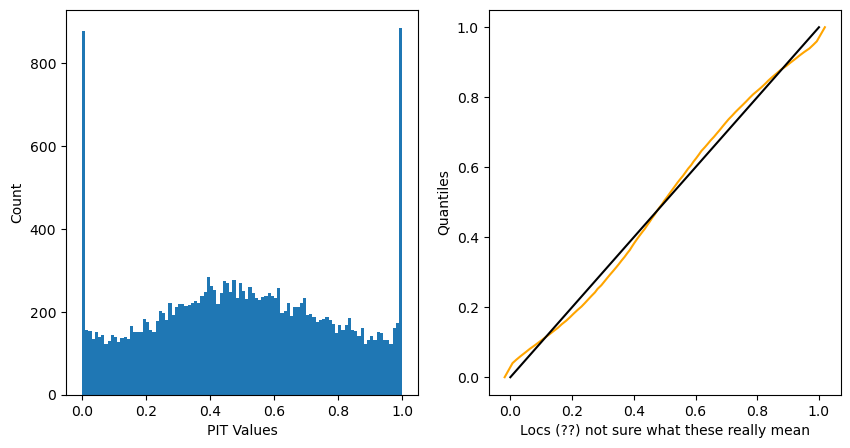

In [ ]:
arr = arr = np.arange(0, 1.1, 0.1)

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5)) 
axes[1].plot(locs[0], quants[0], color = 'orange')
axes[1].plot(arr, arr, color = 'black')
axes[1].set_xlabel('Locs (??) not sure what these really mean')
axes[1].set_ylabel('Quantiles')
axes[0].hist(pit_vals, bins = 100)
axes[0].set_xlabel('PIT Values')
axes[0].set_ylabel('Count')


print(pit_vals)

In [ ]:
#these are analysis (shown in the demo) that has been done already 

ad = metamets['ad'] ## Anderson-Darling stats
cvm = metamets['cvm'] ## Cramer - von Mises stats
ks = metamets['ks'] ## Kolmogorov - Smirnov stats 
outlier_rate = metamets['outlier_rate'] ## 0.05873797877466336


In [ ]:
ks_stat_and_pval = metamets['ks']
print(f"PIT KS stat and pval: {ks_stat_and_pval}") 
ks_stat_and_pval = pitobj.evaluate_PIT_KS()
print(f"PIT KS stat and pval: {ks_stat_and_pval}")

PIT KS stat and pval: KstestResult(statistic=0.033590049370962216, pvalue=1.7621068075751534e-20, statistic_location=0.9921210288809627, statistic_sign=-1)
PIT KS stat and pval: KstestResult(statistic=0.033590049370962216, pvalue=1.7621068075751534e-20, statistic_location=0.9921210288809627, statistic_sign=-1)


In [ ]:

# ks_plot(pitobj)
# print(f"KS metric of this sample: {ks_stat_and_pval.statistic:.4f}") 


In [ ]:

cvm_stat_and_pval = metamets['cvm']
print(f"PIT CvM stat and pval: {cvm_stat_and_pval}") 
cvm_stat_and_pval = pitobj.evaluate_PIT_CvM()
print(f"PIT CvM stat and pval: {cvm_stat_and_pval}")

print(f"CvM metric of this sample: {cvm_stat_and_pval.statistic:.4f}") 

PIT CvM stat and pval: CramerVonMisesResult(statistic=9.623351996059352, pvalue=9.265035405547906e-10)
PIT CvM stat and pval: CramerVonMisesResult(statistic=9.623351996059352, pvalue=9.265035405547906e-10)
CvM metric of this sample: 9.6234


In [ ]:
cdelossobj = CDELoss(fzdata.data, zgrid, ztrue)

cde_stat_and_pval = cdelossobj.evaluate()
cde_stat_and_pval


print(f"CDE loss of this sample: {cde_stat_and_pval.statistic:.2f}") 

CDE loss of this sample: -6.73


## Done with qp

In [26]:
fzdata_new = DS.read_file('pdfs_data', QPHandle, 'output_test_FZBoost.hdf5')
fzdata_new()

In [36]:
f = DS.read_file('pdfs_data', QPHandle, 'output_truth_post_deg_test.hdf5')
test_yvals = f().objdata()['yvals']
test_xvals = f().metadata()['xvals'][0]
print(test_yvals)

[[2.06062680e+00 4.19933970e-04 3.95488120e-04 ... 3.46585074e-01
  1.38221670e-01 7.10653930e-05]
 [1.24810709e-07 2.51317574e-10 7.90716925e-10 ... 7.31942274e-11
  1.77794894e-11 8.50170789e-12]
 [6.86236822e-08 2.14908565e-14 1.80253289e-12 ... 5.34734900e-18
  4.38529932e-16 5.17212755e-19]
 ...
 [5.78491504e-20 1.14111521e-25 1.73014565e-25 ... 2.48570404e-21
  6.38470781e-23 1.07858054e-22]
 [5.78283765e-10 1.47775566e-13 1.06559308e-13 ... 7.46700111e-12
  1.21177124e-11 1.80878753e-11]
 [6.11840774e-16 4.73328654e-20 2.16131233e-19 ... 1.47306763e-25
  2.10235095e-25 1.19551539e-24]]


~1 min

In [100]:
# only run if you need evval_pit again 

# from qp.metrics.pit import PIT
# type(fzdata_new())
# help(PIT)
# test_pit = PIT(fzdata_new(), z_true)

# eval_pit = test_pit._pit_samps 

Help on class PIT in module qp.metrics.pit:

class PIT(builtins.object)
 |  PIT(qp_ens, true_vals, eval_grid=array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
 |         0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
 |         0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
 |         0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
 |         0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
 |         0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
 |         0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
 |         0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
 |         0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
 |         0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
 |         0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
 |         0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
 |         0.60606061, 0.61616162, 0.626262

In [102]:
# type(eval_pit)
# np.save('pit_output.npy', eval_pit)

In [104]:
eval_pit = np.load('pit_output.npy')

array([ True,  True,  True, ...,  True,  True,  True])

In [122]:

a[1]

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

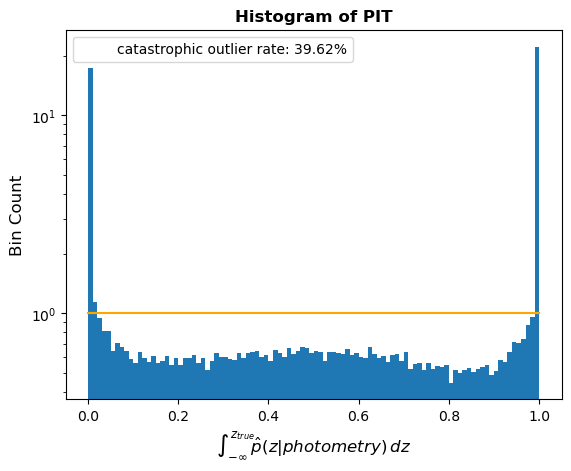

In [225]:
a = plt.hist(eval_pit, bins = 100, density = True)
plt.semilogy()

import scipy.stats 
from scipy.stats import uniform 

na = plt.plot(a[1], np.ones(len(a[0])+1), label = "catastrophic outlier rate: 39.62%", color = 'white')
plt.plot(a[1], uniform().pdf(a[1]), color = 'orange')
plt.title("Histogram of PIT", fontweight = 'bold')
plt.xlabel('$\int_{-\infty}^{z_{true}} \! \hat{p}(z|photometry) \, dz $', fontsize = 'large')
plt.ylabel('Bin Count', fontsize = 'large')
plt.legend(handles = na)
## catastrophic outliers: sum of # of points outside 3 sigma / total 


## integral from -inf to ztrue of (estimated) p(z|photometry) dz ** denote estimation with a hat on the p 

In [115]:
help(uniform)

Help on uniform_gen in module scipy.stats._continuous_distns:

<scipy.stats._continuous_distns.uniform_gen object>
    A uniform continuous random variable.
    
    In the standard form, the distribution is uniform on ``[0, 1]``. Using
    the parameters ``loc`` and ``scale``, one obtains the uniform distribution
    on ``[loc, loc + scale]``.
    
    As an instance of the `rv_continuous` class, `uniform` object inherits from it
    a collection of generic methods (see below for the full list),
    and completes them with details specific for this particular distribution.
    
    Methods
    -------
    rvs(loc=0, scale=1, size=1, random_state=None)
        Random variates.
    pdf(x, loc=0, scale=1)
        Probability density function.
    logpdf(x, loc=0, scale=1)
        Log of the probability density function.
    cdf(x, loc=0, scale=1)
        Cumulative distribution function.
    logcdf(x, loc=0, scale=1)
        Log of the cumulative distribution function.
    sf(x, loc=0, s

In [110]:
print(a[0])

(a[0][0] + a[0][-1]) / np.sum(a[0])

[17380.  1137.   951.   817.   809.   647.   709.   678.   644.   588.
   557.   634.   596.   568.   606.   561.   574.   608.   547.   597.
   548.   594.   591.   618.   562.   596.   518.   574.   627.   600.
   603.   584.   579.   632.   596.   627.   640.   643.   600.   618.
   575.   649.   630.   604.   665.   621.   642.   673.   666.   627.
   641.   637.   574.   637.   636.   628.   623.   663.   616.   627.
   601.   596.   675.   624.   595.   609.   566.   617.   622.   575.
   636.   525.   552.   561.   519.   560.   525.   542.   532.   546.
   446.   518.   496.   516.   531.   504.   520.   536.   548.   488.
   510.   582.   569.   640.   712.   703.   741.   870.   961. 22239.]


0.39619

In [88]:
train_ens = deg_train_pdf_data['yvals'] ## yvals, 100 grid 
deg_train_pdf_meta ## xvals 

# test_ens = deg_test_pdf_data['yvals'] ## yvals 
# deg_test_pdf_meta ## xvals 

eval_ens_yvals = fzdata_new().objdata()['yvals']
eval_ens_xvals = fzdata_new().metadata()['xvals'][0]



NameError: name 'deg_train_pdf_data' is not defined

In [87]:
# interp_dist = qp.interp(xvals=test_xvals, yvals=test_yvals) 

test_ens = qp.Ensemble(qp.interp, data=dict(xvals=test_xvals, yvals=test_yvals))
est_ens = qp.Ensemble(qp.interp, data=dict(xvals=eval_ens_xvals, yvals=eval_ens_yvals))

# "qp.interp" for first arg
# xvals and yvals are keys in a dictionary, that's "data"

NameError: name 'test_xvals' is not defined

In [40]:
print(test_ens.npdf)

100000


In [86]:
## next time you do this, maybe use 101, for easier math 

lims = np.array([0, 2.5])
grid = np.linspace(0, 2.5, 100)

klds_2 = qp.metrics.calculate_kld(test_ens, est_ens, limits=lims, dx = grid[1] - grid[0])
print("KLD value is:", klds_2)


NameError: name 'test_ens' is not defined

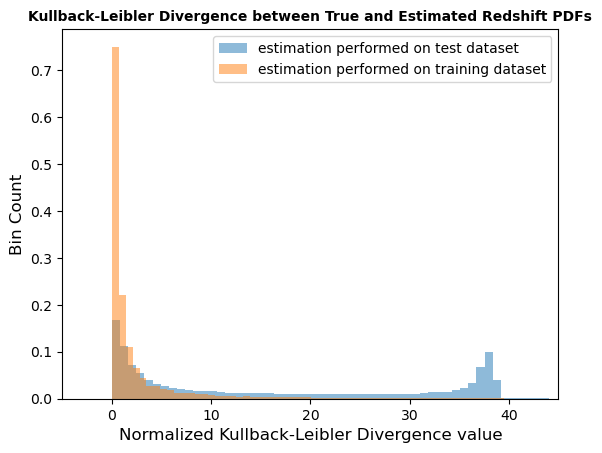

In [266]:
fig, ax = plt.subplots()
test = ax.hist(klds_2, bins = 100, density = True, alpha = 0.5, label = "estimation performed on test dataset")
ax.set_xlim(-5, 45)
# plt.semilogy()
train = ax.hist(klds_1, bins = 100, density = True, alpha = 0.5, label = 'estimation performed on training dataset')
ax.set_ylabel("Bin Count", fontsize = 'large')
ax.set_xlabel("Normalized Kullback-Leibler Divergence value", fontsize = 'large')
ax.set_title("Kullback-Leibler Divergence between True and Estimated Redshift PDFs", fontweight = 'bold', fontsize = 'medium')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
#ax.legend(handles = [test, train])

In [143]:
help(qp.metrics.calculate_kld)

Help on function calculate_kld in module qp.metrics.metrics:

calculate_kld(p, q, limits, dx=0.01)
    Calculates the Kullback-Leibler Divergence between two qp.Ensemble objects.
    
    Parameters
    ----------
    p: Ensemble object
        probability distribution whose distance _from_ `q` will be calculated.
    q: Ensemble object
        probability distribution whose distance _to_ `p` will be calculated.
    limits: tuple of floats
        endpoints of integration interval in which to calculate KLD
    dx: float
        resolution of integration grid
    
    Returns
    -------
    Dpq: float
        the value of the Kullback-Leibler Divergence from `q` to `p`
    
    Notes
    -----
    TO DO: have this take number of points not dx!



# Slide Plots 

In [10]:
orig_train_data
deg_train_data
orig_test_data
deg_test_data

## KLD Attempt [utter failiure :))) ]

In [100]:
## note: I am writing this because for whatever reason the actual kld function in qp isn't behaving and i completely cannot figure out why 
## ens1 and ens2 aren't actually ensembles, I'm making up something that I can easily construct from the data formats I already have
## they should be multi-dimensional arrays, with this structure: [  [ xvals ] , [ [gal 1 yvals], [gal 2 yvals], ... , [gal n yvals] ]  ]
## number of elements in xvals and each 'gal i yvals' is determined by the grid
## should be 100,000 gals 
## ens1 and ens2 must have the same xvals

def kld(ens1, ens2):
    if np.all(ens1[0]) != np.all(ens2[0]):
        print('error: xvals not the same')
    kldarr = []
    for i in range(len(ens1[1])):
        a = np.sum(ens1[1][i] * np.log(np.divide(ens1[1][i], ens2[1][i])))
        kldarr.append(a)
    return np.asarray(kldarr)



In [101]:
ens1 = [ [1, 2, 3, 4, 5], [ [1, 2, 3, 2, 1], [1, 4, 9, 4, 1], [1, 8, 27, 8, 1] ] ]
ens2 = [ [1, 2, 3, 4, 5], [ [2, 4, 6, 4, 2], [6, 12, 18, 12, 6], [1, 3, 9, 3, 1] ] ]

kld(ens1, ens2) 

array([ -6.23832463, -18.61074187,  45.35579984])

### Undeg Undeg 

In [173]:
# inform_fzboost_undeg = Inform_FZBoost.make_stage(
#     name='inform_FZBoost_on_undeg', 
#     model='fzboost.pkl', 
#     hdf5_groupname='',
# )

# inform_fzboost_undeg.inform(orig_train_data)

In [172]:
# estimate_fzboost_u_u = FZBoost.make_stage(
#     name='est_FZBoost_u_u', 
#     nondetect_val=np.nan,
#     model=inform_fzboost_undeg.get_handle('model'), 
#     hdf5_groupname='',
#     aliases=dict(input='test_data', output='fzboost_estim'),
#     nzbins = 100 ,
#     zmax = 2.5
# )

# undeg_undeg = estimate_fzboost_u_u.estimate(orig_test_data) 

In [171]:
# import h5py

# f = h5py.File('output_est_FZBoost_u_u.hdf5', 'r')
# list(f.keys())

# ancil = f['ancil']
# data = f['data']
# meta = f['meta']

# zmode = ancil['zmode']
# yvals = data['yvals']
# xvals = meta['xvals']

# print(np.asarray(xvals))
# print(np.asarray(yvals))

In [170]:
# import qp

# u_u = DS.read_file('pdfs_data', QPHandle, 'output_est_FZBoost_u_u.hdf5')
# u_u_yvals = u_u().objdata()['yvals']
# u_u_xvals = u_u().metadata()['xvals'][0]
# u_u_ens = qp.Ensemble(qp.interp, data=dict(xvals=u_u_xvals, yvals=u_u_yvals))

# u_u_true = DS.read_file('pdfs_data', QPHandle, 'output_truth_post_orig_test.hdf5') 
# u_u_true_yvals = u_u_true().objdata()['yvals']
# u_u_true_xvals = u_u_true().metadata()['xvals'][0]
# u_u_true_ens = qp.Ensemble(qp.interp, data=dict(xvals=u_u_true_xvals, yvals=u_u_true_yvals))

In [169]:
# asdf = np.asarray(u_u_yvals)
# ct = 0
# for i in asdf:
#     for j in i:
#         if j != 0:
#             ct += 1
# print(ct)
# print(len(asdf) * len(asdf[0]))
# print(u_u_yvals)

In [168]:
# y1 = np.asarray(u_u_yvals)
# x1 = np.asarray(u_u_xvals)
# u_u = [x1, y1]

# y2 = np.asarray(u_u_true_yvals)
# x2 = np.asarray(u_u_true_xvals)
# u_u_tru = [x2, y2]

# ct = 0
# for i in kld(u_u_tru, u_u):
#     if np.isfinite(i) == True:
#         ct += 1
# print(ct)

In [167]:
# lims = np.array([0, 2.5])
# grid = np.linspace(0, 2.5, 101)

# u_u_kld = qp.metrics.calculate_kld(u_u_true_ens, u_u_ens, limits=lims, dx = grid[1] - grid[0])
# print(u_u_kld)

### Undeg Deg 

In [163]:
# estimate_fzboost_u_d = FZBoost.make_stage(
#     name='est_FZBoost_u_d', 
#     nondetect_val=np.nan,
#     model=inform_fzboost_undeg.get_handle('model'), 
#     hdf5_groupname='',
#     aliases=dict(input='test_data', output='fzboost_estim'),
#     nzbins = 100 ,
#     zmax = 2.5
# )

# undeg_deg = estimate_fzboost_u_d.estimate(deg_test_data) 

In [164]:
# import qp

# u_d = DS.read_file('pdfs_data', QPHandle, 'output_est_FZBoost_u_d.hdf5')
# u_d_yvals = u_d().objdata()['yvals']
# u_d_xvals = u_d().metadata()['xvals'][0]
# u_d_ens = qp.Ensemble(qp.interp, data=dict(xvals=u_d_xvals, yvals=u_d_yvals))

# u_d_true = DS.read_file('pdfs_data', QPHandle, 'output_truth_post_deg_test.hdf5') 
# u_d_true_yvals = u_d_true().objdata()['yvals']
# u_d_true_xvals = u_d_true().metadata()['xvals'][0]
# u_d_true_ens = qp.Ensemble(qp.interp, data=dict(xvals=u_d_true_xvals, yvals=u_d_true_yvals))

In [165]:
# y3 = np.asarray(u_d_yvals)
# x3 = np.asarray(u_d_xvals)
# u_d = [x3, y3]

# y4 = np.asarray(u_d_true_yvals)
# x4 = np.asarray(u_d_true_xvals)
# u_d_tru = [x4, y4]

# ct = 0
# for i in kld(u_d,u_d_tru ):
#     if np.isfinite(i) == True:
#         ct += 1
#         print(i)
# print(ct)

In [166]:
# lims = np.array([0, 2.5])
# grid = np.linspace(0, 2.5, 101)

# u_d_kld = qp.metrics.calculate_kld(u_d_true_ens, u_d_ens, limits=lims, dx = grid[1] - grid[0])

# print(u_d_kld)


In [82]:
help(qp.metrics.calculate_kld)

Help on function calculate_kld in module qp.metrics.metrics:

calculate_kld(p, q, limits, dx=0.01)
    Calculates the Kullback-Leibler Divergence between two qp.Ensemble objects.
    
    Parameters
    ----------
    p: Ensemble object
        probability distribution whose distance _from_ `q` will be calculated.
    q: Ensemble object
        probability distribution whose distance _to_ `p` will be calculated.
    limits: tuple of floats
        endpoints of integration interval in which to calculate KLD
    dx: float
        resolution of integration grid
    
    Returns
    -------
    Dpq: float
        the value of the Kullback-Leibler Divergence from `q` to `p`
    
    Notes
    -----
    TO DO: have this take number of points not dx!



### Deg Undeg 

In [159]:
# inform_fzboost_deg = Inform_FZBoost.make_stage(
#     name='inform_FZBoost_on_deg', 
#     model='fzboost.pkl', 
#     hdf5_groupname='',
# )

# inform_fzboost_deg.inform(deg_train_data)

In [160]:
# estimate_fzboost = FZBoost.make_stage(
#     name='est_FZBoost_d_u', 
#     nondetect_val=np.nan,
#     model=inform_fzboost_deg.get_handle('model'), 
#     hdf5_groupname='',
#     aliases=dict(input='test_data', output='fzboost_estim'),
#     nzbins = 100 ,
#     zmax = 2.5
# )

# deg_undeg = estimate_fzboost.estimate(orig_test_data) 

In [161]:
# import qp

# d_u = DS.read_file('pdfs_data', QPHandle, 'output_est_FZBoost_d_u.hdf5')
# d_u_yvals = d_u().objdata()['yvals']
# d_u_xvals = d_u().metadata()['xvals'][0]
# d_u_ens = qp.Ensemble(qp.interp, data=dict(xvals=d_u_xvals, yvals=d_u_yvals))

# d_u_true = DS.read_file('pdfs_data', QPHandle, 'output_truth_post_orig_test.hdf5') 
# d_u_true_yvals = d_u_true().objdata()['yvals']
# d_u_true_xvals = d_u_true().metadata()['xvals'][0]
# d_u_true_ens = qp.Ensemble(qp.interp, data=dict(xvals=d_u_true_xvals, yvals=d_u_true_yvals))

In [162]:
# lims = np.array([0, 2.5])
# grid = np.linspace(0, 2.5, 101)

# d_u_kld = qp.metrics.calculate_kld(d_u_true_ens, d_u_ens, limits=lims, dx = grid[1] - grid[0])

### Deg Deg 

In [156]:
# estimate_fzboost = FZBoost.make_stage(
#     name='est_FZBoost_d_d', 
#     nondetect_val=np.nan,
#     model=inform_fzboost_deg.get_handle('model'), 
#     hdf5_groupname='',
#     aliases=dict(input='test_data', output='fzboost_estim'),
#     nzbins = 100 ,
#     zmax = 2.5
# )

# deg_deg = estimate_fzboost.estimate(deg_test_data) 

In [157]:
# import qp

# d_d = DS.read_file('pdfs_data', QPHandle, 'output_est_FZBoost_d_d.hdf5')
# d_d_yvals = d_d().objdata()['yvals']
# d_d_xvals = d_d().metadata()['xvals'][0]
# d_d_ens = qp.Ensemble(qp.interp, data=dict(xvals=d_d_xvals, yvals=d_d_yvals))

# d_d_true = DS.read_file('pdfs_data', QPHandle, 'output_truth_post_deg_test.hdf5') 
# d_d_true_yvals = d_d_true().objdata()['yvals']
# d_d_true_xvals = d_d_true().metadata()['xvals'][0]
# d_d_true_ens = qp.Ensemble(qp.interp, data=dict(xvals=d_d_true_xvals, yvals=d_d_true_yvals))

In [158]:
# lims = np.array([0, 2.5])
# grid = np.linspace(0, 2.5, 101)

# d_d_kld = qp.metrics.calculate_kld(d_d_true_ens, d_d_ens, limits=lims, dx = grid[1] - grid[0])

### Plot 

In [155]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots()
# u_u = ax.hist(u_u_kld, bins = 100, density = True, alpha = 0.5, label = 'u_u')
# # u_d = ax.hist(u_d_kld, bins = 100, density = True, alpha = 0.5, label = 'u_d')
# # d_u = ax.hist(d_u_kld, bins = 100, density = True, alpha = 0.5, label = 'd_u')
# # d_d = ax.hist(d_d_kld, bins = 100, density = True, alpha = 0.5, label = 'd_d')
# ax.set_xlim(0, 0.1)
# # plt.semilogy()
# ax.set_ylabel("Bin Count", fontsize = 'large')
# ax.set_xlabel("Normalized Kullback-Leibler Divergence value", fontsize = 'large')
# ax.set_title("Kullback-Leibler Divergence Histogram", fontweight = 'bold', fontsize = 'medium')
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels)

## Outlier Rejection Instead (?)

### Inverse Redshift Incompleteness

In [218]:
import numpy as np
from scipy import stats
from scipy.stats import norm

def getMeans(ens):
    means = []
    for i in range(len(ens[1])):
        mean = np.sum(ens[0] * ens[1][i]) / np.sum(ens[1][i])
        means.append(mean)
    return np.asarray(means)
        # var = np.sum((mean - ens[0])**2 * ens[1][i]) / np.sum(ens[1][i])

def outlierRejection(ls, lim):
    mean = np.mean(ls)
    stdev = stats.tstd(ls)
    ct = 0
    for i in ls:
        if np.abs(mean - i) > 3*stdev:
            ls.remove(i) 
            ct += 1
    if ct <= lim:
        return ls
    else:
        return outlierRejection(ls, lim)


#### Inform on undegraded training set 

##### Info 

In [145]:
## inform on undegraded training set 

inform_fzboost_undeg_train = Inform_FZBoost.make_stage(
    name='inform_FZBoost_undeg_train', 
    model='fzboost.pkl', 
    hdf5_groupname='',
)

inform_fzboost_undeg_train.inform(orig_train_data)

stacking some data...
read in training data
fit the model...
[22:31:04] WARNING: /private/var/folders/jl/5jxwvx_x5q364l56c4qph1g00000gn/T/pip-install-eeaedq5e/xgboost_e2bb7fd5d4194af8881e01ff690195d0/build/temp.macosx-11.0-arm64-cpython-310/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[22:31:04] WARNING: /private/var/folders/jl/5jxwvx_x5q364l56c4qph1g00000gn/T/pip-install-eeaedq5e/xgboost_e2bb7fd5d4194af8881e01ff690195d0/build/temp.macosx-11.0-arm64-cpython-310/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[22:31:04] WARNING: /private/var/folders/jl/5jxwvx_x5q364l56c4qph1g00000gn/T/pip-install-eeaedq5e/xgboost_e2bb7fd5d4194af8881e01ff690195d0/build/temp.macosx-11.0-arm64-cpython-310/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[22:31:04] WARNING: /private/var/folders/jl/5jxwvx_x5q364l56c4qph1g00000gn/T/pip-install-eeaedq5e/xgboost_e2bb7fd5d4194af8881e01ff690195d0/build/temp.macosx-11.0-arm64-cpython-310/xgboost/src/

NOTE/WARNING: Expected output file fzboost.pkl was not generated.


##### Estimation

In [174]:
## estimate on same data set that we informed on 

estimate_fzboost_undeg_undeg_train = FZBoost.make_stage(
    name='est_FZBoost_u_u_train', 
    nondetect_val=np.nan,
    model=inform_fzboost_undeg_train.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='fzboost_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

## this should do very well!! 
undeg_undeg_train = estimate_fzboost_undeg_undeg_train.estimate(orig_train_data)

Process 0 running estimator on chunk 0 - 10000
Process 0 estimating PZ PDF for rows 0 - 10,000
Inserting handle into data store.  output_est_FZBoost_u_u_train: inprogress_output_est_FZBoost_u_u_train.hdf5, est_FZBoost_u_u_train


In [175]:
## estimate on degraded version of the dataset we informed with (degraded using inv z incompleteness)

estimate_fzboost_undeg_deg_train = FZBoost.make_stage(
    name='est_FZBoost_u_d_train', 
    nondetect_val=np.nan,
    model=inform_fzboost_undeg_train.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='fzboost_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

## should do less well !! 
undeg_deg_train = estimate_fzboost_undeg_deg_train.estimate(deg_train_data)

Process 0 running estimator on chunk 0 - 8315
Process 0 estimating PZ PDF for rows 0 - 8,315
Inserting handle into data store.  output_est_FZBoost_u_d_train: inprogress_output_est_FZBoost_u_d_train.hdf5, est_FZBoost_u_d_train


##### Outlier Rej 

In [245]:
import h5py

u_u_f = h5py.File('output_est_FZBoost_u_u_train.hdf5', 'r')
list(u_u_f.keys())

u_u_ancil = u_u_f['ancil']
u_u_data = u_u_f['data']
u_u_meta = u_u_f['meta']

u_u_zmode = u_u_ancil['zmode']
u_u_yvals = np.asarray(u_u_data['yvals'])
u_u_xvals = np.asarray(u_u_meta['xvals'])[0]

u_u_means = getMeans([u_u_xvals, u_u_yvals])

print(len(u_u_means))

10000


In [244]:
u_d_f = h5py.File('output_est_FZBoost_u_d_train.hdf5', 'r')
list(u_d_f.keys())

u_d_ancil = u_d_f['ancil']
u_d_data = u_d_f['data']
u_d_meta = u_d_f['meta']

u_d_zmode = u_d_ancil['zmode']
u_d_yvals = np.asarray(u_d_data['yvals'])
u_d_xvals = np.asarray(u_d_meta['xvals'])[0]

u_d_means = getMeans([u_d_xvals, u_d_yvals])

print(len(u_d_means))

8315


In [256]:
## need to run cell at the top that defines redshfit_1 for this to work :) 

u_u_true_z = redshift_1

u_u_diff = np.asarray(u_u_true_z - u_u_means)

u_u_oR = outlierRejection(u_u_diff.tolist(), 0)

print(u_u_oR)

u_u_inds = []
for i in range(len(u_u_oR)):
    u_u_inds.append(np.where(u_u_diff == u_u_oR[i])[0][0])
print(u_u_inds)

u_u_kept = []
u_u_kept_z = []
for i in u_u_inds:
    u_u_kept.append(u_u_means[i])
    u_u_kept_z.append(u_u_true_z[i])
u_u_kept = np.asarray(u_u_kept)
u_u_kept_z= np.asarray(u_u_kept_z)

[0.0006783991819414026, 0.0008849033326064348, 0.0014534337253977458, 0.00528722186671049, -0.001044879480832317, -0.0018806684966583553, 0.005915120591190259, -0.008511888078909902, 0.014922801997586665, 0.004900102349346902, -0.013470859171685223, -0.0021767451077081557, -0.0038446946689540407, 0.0008398745950148889, -0.0015709006153421523, -0.0030614240186137565, -0.003043667620468815, -0.0006020194549339886, 0.0019336936150764483, -0.006077629703876264, 0.003913061816792629, 0.007258443487842103, -0.0008820849188263535, -0.0063983686361044345, 0.017375023686345026, 0.0003041665698613194, 0.000980509556207848, -0.005319835589792876, -0.002420016336432851, 0.0053411119463582235, 0.0016272645896204807, -0.006771703940278817, -0.00036124133263892855, -0.0030218598367390825, 0.0020347349175909857, 0.001577484425422604, 0.003249571681484653, 0.0006415051780412351, -0.0009639587412224593, -0.002767662164428586, 0.002449734837364881, 0.0068665725556862345, 0.0004820966991325726, 0.00183898

In [242]:
## need to run cell at the top that defines redshfit_2 for this to work :) 

u_d_true_z = redshift_2

u_d_diff = np.asarray(u_d_true_z - u_d_means)

u_d_oR = outlierRejection(u_d_diff.tolist(), 0)

print(u_d_oR)

u_d_inds = []
for i in range(len(u_d_oR)):
    u_d_inds.append(np.where(u_d_diff == u_d_oR[i])[0][0])
print(u_d_inds)

u_d_kept = []
u_d_kept_z = []
for i in u_d_inds:
    u_d_kept.append(u_d_means[i])
    u_d_kept_z.append(u_d_true_z[i])
u_d_kept = np.asarray(u_d_kept)
u_d_kept_z= np.asarray(u_d_kept_z)

[0.0006783991819414026, 0.0008849033326064348, 0.0014534337253977458, 0.00528722186671049, -0.001044879480832317, -0.0018806684966583553, -0.008511888078909902, 0.014922801997586665, 0.004900102349346902, -0.0021767451077081557, -0.0038446946689540407, 0.0008398745950148889, -0.0015709006153421523, -0.0030614240186137565, -0.003043667620468815, -0.0006020194549339886, 0.0019336936150764483, -0.006077629703876264, 0.003913061816792629, 0.007258443487842103, -0.0008820849188263535, -0.0063983686361044345, 0.0003041665698613194, 0.000980509556207848, -0.005319835589792876, -0.002420016336432851, 0.0053411119463582235, 0.0016272645896204807, -0.006771703940278817, -0.00036124133263892855, -0.0030218598367390825, 0.0020347349175909857, 0.001577484425422604, 0.003249571681484653, 0.0006415051780412351, -0.0009639587412224593, -0.002767662164428586, 0.002449734837364881, 0.0068665725556862345, 0.0004820966991325726, 0.0018389875869140315, -0.0007398463864243254, 0.012862629239359435, 0.000242

#### Inform on degraded training set 

##### Info 

In [153]:
inform_fzboost_deg_train = Inform_FZBoost.make_stage(
    name='inform_FZBoost_deg_train', 
    model='fzboost.pkl', 
    hdf5_groupname='',
)

inform_fzboost_deg_train.inform(deg_train_data)

stacking some data...
read in training data
fit the model...
[22:46:14] WARNING: /private/var/folders/jl/5jxwvx_x5q364l56c4qph1g00000gn/T/pip-install-eeaedq5e/xgboost_e2bb7fd5d4194af8881e01ff690195d0/build/temp.macosx-11.0-arm64-cpython-310/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[22:46:14] WARNING: /private/var/folders/jl/5jxwvx_x5q364l56c4qph1g00000gn/T/pip-install-eeaedq5e/xgboost_e2bb7fd5d4194af8881e01ff690195d0/build/temp.macosx-11.0-arm64-cpython-310/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[22:46:14] WARNING: /private/var/folders/jl/5jxwvx_x5q364l56c4qph1g00000gn/T/pip-install-eeaedq5e/xgboost_e2bb7fd5d4194af8881e01ff690195d0/build/temp.macosx-11.0-arm64-cpython-310/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[22:46:14] WARNING: /private/var/folders/jl/5jxwvx_x5q364l56c4qph1g00000gn/T/pip-install-eeaedq5e/xgboost_e2bb7fd5d4194af8881e01ff690195d0/build/temp.macosx-11.0-arm64-cpython-310/xgboost/src/

NOTE/WARNING: Expected output file fzboost.pkl was not generated.


##### Estimation 

In [246]:
estimate_fzboost_deg_undeg_train = FZBoost.make_stage(
    name='est_FZBoost_d_u_train', 
    nondetect_val=np.nan,
    model=inform_fzboost_deg_train.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='fzboost_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

## this should do very well!! 
deg_undeg_train = estimate_fzboost_deg_undeg_train.estimate(orig_train_data)

Process 0 running estimator on chunk 0 - 10000
Process 0 estimating PZ PDF for rows 0 - 10,000
Inserting handle into data store.  output_est_FZBoost_d_u_train: inprogress_output_est_FZBoost_d_u_train.hdf5, est_FZBoost_d_u_train


In [247]:
estimate_fzboost_deg_deg_train = FZBoost.make_stage(
    name='est_FZBoost_d_d_train', 
    nondetect_val=np.nan,
    model=inform_fzboost_deg_train.get_handle('model'), 
    hdf5_groupname='',
    aliases=dict(input='test_data', output='fzboost_estim'),
    nzbins = 100 ,
    zmax = 2.5
)

## this should do very well!! 
deg_deg_train = estimate_fzboost_deg_deg_train.estimate(deg_train_data)

Process 0 running estimator on chunk 0 - 8315
Process 0 estimating PZ PDF for rows 0 - 8,315
Inserting handle into data store.  output_est_FZBoost_d_d_train: inprogress_output_est_FZBoost_d_d_train.hdf5, est_FZBoost_d_d_train


##### Outlier Rej 

In [249]:
import h5py

d_u_f = h5py.File('output_est_FZBoost_d_u_train.hdf5', 'r')
list(d_u_f.keys())

d_u_ancil = d_u_f['ancil']
d_u_data = d_u_f['data']
d_u_meta = d_u_f['meta']

d_u_zmode = d_u_ancil['zmode']
d_u_yvals = np.asarray(d_u_data['yvals'])
d_u_xvals = np.asarray(d_u_meta['xvals'])[0]

d_u_means = getMeans([d_u_xvals, d_u_yvals])

print(len(d_u_means))

10000


In [250]:
d_d_f = h5py.File('output_est_FZBoost_d_d_train.hdf5', 'r')
list(d_d_f.keys())

d_d_ancil = d_d_f['ancil']
d_d_data = d_d_f['data']
d_d_meta = d_d_f['meta']

d_d_zmode = d_d_ancil['zmode']
d_d_yvals = np.asarray(d_d_data['yvals'])
d_d_xvals = np.asarray(d_d_meta['xvals'])[0]

d_d_means = getMeans([d_d_xvals, d_d_yvals])

print(len(d_d_means))

8315


In [251]:
d_u_true_z = redshift_1

d_u_diff = np.asarray(d_u_true_z - d_u_means)

d_u_oR = outlierRejection(d_u_diff.tolist(), 0)

print(d_u_oR)

d_u_inds = []
for i in range(len(d_u_oR)):
    d_u_inds.append(np.where(d_u_diff == d_u_oR[i])[0][0])
print(d_u_inds)

d_u_kept = []
d_u_kept_z = []
for i in d_u_inds:
    d_u_kept.append(d_u_means[i])
    d_u_kept_z.append(d_u_true_z[i])
d_u_kept = np.asarray(d_u_kept)
d_u_kept_z= np.asarray(d_u_kept_z)

[0.0006783991819414026, 0.0008849033326064348, 0.0014534337253977458, 0.00528722186671049, -0.001044879480832317, -0.0018806684966583553, 0.005915120591190259, -0.008511888078909902, 0.014922801997586665, 0.004900102349346902, -0.013470859171685223, -0.0021767451077081557, -0.0038446946689540407, 0.0008398745950148889, -0.0015709006153421523, -0.0030614240186137565, -0.003043667620468815, -0.0006020194549339886, 0.0019336936150764483, -0.006077629703876264, 0.003913061816792629, 0.007258443487842103, -0.0008820849188263535, -0.0063983686361044345, 0.017375023686345026, 0.0003041665698613194, 0.000980509556207848, -0.005319835589792876, -0.002420016336432851, 0.0053411119463582235, 0.0016272645896204807, -0.006771703940278817, -0.00036124133263892855, -0.0030218598367390825, 0.0020347349175909857, 0.001577484425422604, 0.003249571681484653, 0.0006415051780412351, -0.0009639587412224593, -0.002767662164428586, 0.002449734837364881, 0.0068665725556862345, 0.0004820966991325726, 0.00183898

In [252]:
d_d_true_z = redshift_2

d_d_diff = np.asarray(d_d_true_z - d_d_means)

d_d_oR = outlierRejection(d_d_diff.tolist(), 0)

print(d_d_oR)

d_d_inds = []
for i in range(len(d_d_oR)):
    d_d_inds.append(np.where(d_d_diff == d_d_oR[i])[0][0])
print(d_d_inds)

d_d_kept = []
d_d_kept_z = []
for i in d_d_inds:
    d_d_kept.append(d_d_means[i])
    d_d_kept_z.append(d_d_true_z[i])
d_d_kept = np.asarray(d_d_kept)
d_d_kept_z= np.asarray(d_d_kept_z)

[0.0006783991819414026, 0.0008849033326064348, 0.0014534337253977458, 0.00528722186671049, -0.001044879480832317, -0.0018806684966583553, -0.008511888078909902, 0.014922801997586665, 0.004900102349346902, -0.0021767451077081557, -0.0038446946689540407, 0.0008398745950148889, -0.0015709006153421523, -0.0030614240186137565, -0.003043667620468815, -0.0006020194549339886, 0.0019336936150764483, -0.006077629703876264, 0.003913061816792629, 0.007258443487842103, -0.0008820849188263535, -0.0063983686361044345, 0.0003041665698613194, 0.000980509556207848, -0.005319835589792876, -0.002420016336432851, 0.0053411119463582235, 0.0016272645896204807, -0.006771703940278817, -0.00036124133263892855, -0.0030218598367390825, 0.0020347349175909857, 0.001577484425422604, 0.003249571681484653, 0.0006415051780412351, -0.0009639587412224593, -0.002767662164428586, 0.002449734837364881, 0.0068665725556862345, 0.0004820966991325726, 0.0018389875869140315, -0.0007398463864243254, 0.012862629239359435, 0.000242

#### Catastrophic Outlier Rates

In [272]:
print(((len(u_u_means) - len(u_u_kept)) / len(u_u_means)) * 100)

print(((len(u_d_means) - len(u_d_kept)) / len(u_d_means)) * 100)

print(((len(d_u_means) - len(d_u_kept)) / len(d_u_means)) * 100)

print(((len(d_d_means) - len(d_d_kept)) / len(d_d_means)) * 100)



23.13
16.103427540589298
23.13
16.103427540589298


#### Plots

Text(0, 0.5, 'Trained on Degraded Data')

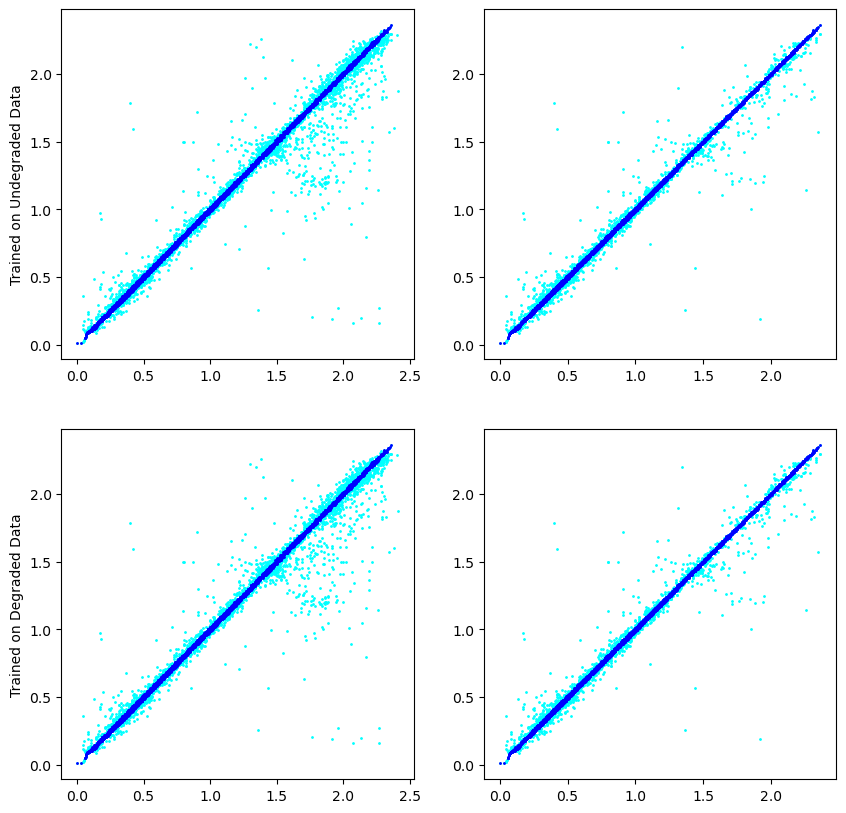

In [270]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))
axes[0][0].scatter(u_u_true_z, u_u_means, s = 1, color = 'cyan')
axes[0][0].scatter(u_u_kept_z, u_u_kept, s = 1, color = 'blue')

axes[0][1].scatter(u_d_true_z, u_d_means, s = 1, color = 'cyan')
axes[0][1].scatter(u_d_kept_z, u_d_kept, s = 1, color = 'blue')

axes[1][0].scatter(d_u_true_z, d_u_means, s = 1, color = 'cyan')
axes[1][0].scatter(d_u_kept_z, d_u_kept, s = 1, color = 'blue')

axes[1][1].scatter(d_d_true_z, d_d_means, s = 1, color = 'cyan')
axes[1][1].scatter(d_d_kept_z, d_d_kept, s = 1, color = 'blue')

axes[0][0].set_ylabel("Trained on Undegraded Data")
axes[1][0].set_ylabel("Trained on Degraded Data")

# Convert to Ceci Pipeline

In [ ]:
import ceci
pipe = ceci.Pipeline.interactive()
stages = [
    # train the flow
    flow_modeler,
    # create the training catalog
    flow_creator_train,  inv_redshift_deg,
    # column and table stages 
    col_remapper, table_conv,
    # create the test catalog
    flow_creator_test, lsst_error_model_deg,
    # inform the estimators
    inform_fzboost,
    # estimate posteriors
    estimate_fzboost,
    # evaluate
    # FZB_eval
]
for stage in stages:
    pipe.add_stage(stage)

In [ ]:
pipe.initialize(dict(input=catalog_file), dict(output_dir='.', log_dir='.', resume=False), None)

(({'flow_modeler': <Job flow_modeler>,
   'flow_creator_test': <Job flow_creator_test>,
   'lsst_error_model_deg': <Job lsst_error_model_deg>,
   'col_remapper': <Job col_remapper>,
   'table_conv': <Job table_conv>,
   'flow_creator_train': <Job flow_creator_train>,
   'inv_redshift_deg': <Job inv_redshift_deg>,
   'inform_FZBoost': <Job inform_FZBoost>,
   'test_FZBoost': <Job test_FZBoost>},
   LSSTErrorModel parameters:
   
   Model for bands: mag_u_lsst, mag_g_lsst, mag_r_lsst, mag_i_lsst, mag_z_lsst, mag_y_lsst
   
   Using error type point
   Exposure time = 30.0 s
   Number of years of observations = 10.0
   Mean visits per year per band:
      mag_u_lsst: 5.6, mag_g_lsst: 8.0, mag_r_lsst: 18.4, mag_i_lsst: 18.4, mag_z_lsst: 16.0, mag_y_lsst: 16.0
   Airmass = 1.2
   Irreducible system error = 0.005
   Magnitudes dimmer than 30.0 are set to nan
   gamma for each band:
      mag_u_lsst: 0.038, mag_g_lsst: 0.039, mag_r_lsst: 0.039, mag_i_lsst: 0.039, mag_z_lsst: 0.039, mag_y_lsst

In [ ]:
pipe.save('tmp_goldenspike.yml')

In [ ]:
pr = ceci.Pipeline.read('tmp_goldenspike.yml')

pr.run()


Executing flow_modeler
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowModeler   --input=/Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/base_catalog.pq   --name=flow_modeler   --config=tmp_goldenspike_config.yml   --model=.//Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl 
Output writing to ./flow_modeler.out

Job flow_modeler has completed successfully!

Executing flow_creator_test
Command is:
OMP_NUM_THREADS=1   python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=.//Users/alicec03/Desktop/Summer_Research/Photo-z-Stress-Test/Photo-z-Stress-Test/data/trained_flow.pkl   --name=flow_creator_test   --config=tmp_goldenspike_config.yml   --output=./output_flow_creator_test.pq 
Output writing to ./flow_creator_test.out

Job flow_creator_test has completed successfully!

Executing lsst_error_model_deg
Command is:
OMP_NUM_THREADS=1   python3 -m cec

0